In [1]:
# Imports
import sys,os,time,itertools,warnings,copy
from collections import *

# PyData Ecosystem
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn import clone

# Miscellaneous
import ptitprince as pt

# Soothsayer Ecosystem
import soothsayer as sy
from soothsayer.classification import HierarchicalClassifier as HEC
import hive_networkx as hx
import ensemble_networkx as enx
import compositional as coda

# Duration
t0 = time.time()

Soothsayer_v2020.08.12 | 00:00:01


In [2]:
# Utility functions
def plot_distribution(df_data,
                      plot_type="box",
                      size=8,
                      color_fill="darkgray",
                      color_swarm=None,
                      color_density=None,
                      title=None,
                      xlabel=None,
                      ylabel="infer",
                      legend=False,
                      x_rot=90,
                      swarm=True,
                      bins=None,
                      hist=True,
                      rug=False,
                      shade=True,
                      figsize=(13,5),
                      ax=None,
                      style="seaborn-white",
                      fig_kws=dict(),
                      title_kws=dict(),
                      legend_kws=dict(),
                      distr_kws=dict(),
                      swarm_kws=dict(),
                      xtick_kws=dict(),
                      ytick_kws=dict(),
                      axis_kws=dict(),
                      annot_kws=dict(),

                      # Stats
                      show_n=False,
                      pairs=None,
                      stats_width=1,
                      stats_color="black",
                      stats_func=stats.mannwhitneyu,
                      precision=3,
                      stats_kws=dict(),
                      stats_offset=1,
                     ):
    """
    2018-July-2

    Bugs:
    No known bugs
    """
    supported_types = ["box", "violin", "density"]
    assert plot_type in supported_types, f"`plot_type` must be in {supported_types}"

    # DEFAULTS
    DEFAULT_PALETTE = "Set2"

    # Keywords
    _fig_kws = {"figsize":figsize}
    _fig_kws.update(fig_kws)
    _swarm_kws = {"edgecolor":"black", "linewidth":1}
    _swarm_kws.update(swarm_kws)
    _distr_kws = {}
    _distr_kws.update(distr_kws)
    if plot_type == "density":
        _xtick_kws = {"fontsize":15}
        _xtick_kws.update(xtick_kws)
        _ytick_kws = {"fontsize":15}
        _ytick_kws.update(ytick_kws)
    else:
        _xtick_kws = {"fontsize":15, "rotation":x_rot}
        _xtick_kws.update(xtick_kws)
        _ytick_kws = {"fontsize":12}
        _ytick_kws.update(ytick_kws)
    _axis_kws = {"fontsize":15}
    _axis_kws.update(axis_kws)
    _title_kws = {"fontsize":18, "fontweight":"bold"}
    _title_kws.update(title_kws)
    _legend_kws = {'fontsize': 15, 'frameon': True, 'facecolor': 'white', 'edgecolor': 'black', 'loc': 'center left', 'bbox_to_anchor': (1, 0.5)}
    _legend_kws.update(legend_kws)
    _annot_kws = dict(ha='center', va='bottom', fontsize=15) #
    _annot_kws.update(annot_kws)
    _stats_kws=dict(ha='center', va='bottom', color=stats_color, fontsize=15) # ax.text (stats)
    _stats_kws.update(stats_kws)

    # Functions
    def _process_colors(df_data, colors, DEFAULT_PALETTE=DEFAULT_PALETTE):
        if type(colors) == sns.palettes._ColorPalette:
            return colors
        if colors is None:
            return sns.color_palette(palette=DEFAULT_PALETTE, n_colors=df_data.shape[1])

        try:
            return sns.color_palette(palette=colors, n_colors=df_data.shape[1])
        except ValueError:
            is_list_like = lambda x: hasattr(x, '__iter__') and not type(x) == str
            color_missing = "gray"
            if mpl.colors.is_color_like(colors):
                colors = [colors]*df_data.columns.size
            else:
                condition_A = type(colors) == pd.Series
                condition_B = isinstance(colors, (dict, OrderedDict))
                if any([condition_A, condition_B]):
                    colors = df_data.columns.map(lambda x: colors[x] if x in colors else color_missing).tolist()
                condition_C = is_list_like(colors)
                if not condition_C:
                    print(f"Warning: Incorrect colors `{colors}`", file=sys.stderr)
                    colors = [color_missing]*df_data.shape[1]
            return sns.color_palette(palette=colors)


    def _plot_vertical_distribution(df_data, kind, swarm, palette_fill, palette_swarm, distr_kws, swarm_kws, xtick_kws, ytick_kws, ax):
        df_melt = pd.melt(df_data, var_name="variable").dropna(how="any", axis=0).reset_index()
        if plot_type == "box":
            sns.boxplot(data=df_melt, x="variable", y="value", palette=palette_fill, ax=ax, **distr_kws)
        if plot_type == "violin":
            sns.violinplot(data=df_melt, x="variable", y="value",palette=palette_fill, ax=ax, **distr_kws)
        if swarm:
            sns.swarmplot(data=df_melt, x="variable", y="value", size=size, palette=palette_swarm, ax=ax, **swarm_kws)
        ax.set_xticklabels(ax.get_xticklabels(), **xtick_kws)
        ax.set_yticklabels(ax.get_yticks(), **ytick_kws)
        ax.set_xlabel("")
        ax.set_ylabel("")

    def _plot_horizontal_distribution(df_data, bins, rug, shade, palette_density, distr_kws, xtick_kws, ytick_kws, ax):
        for (name, vector), color in zip(df_data.T.iterrows(), palette_density):
            sns.distplot(vector.dropna().values, color=None, hist=hist, rug=rug, kde_kws={"shade":shade}, ax=ax)
        ax.set_xticklabels(ax.get_xticks(), **xtick_kws)
        ax.set_yticklabels(ax.get_yticks(), **ytick_kws)

    def _plot_stats(df_data, pairs, stats_offset, precision, stats_func, stats_color, stats_width, annot_kws, stats_kws):
        stats_offset = max(stats_offset,1e-5)
        # Statistical tests
        x = df_data.values.ravel()
        x = x[np.isfinite(x)]
        pad_y = (x.max() - x.min())*5e-2
        if show_n:
            for j in range(df_data.shape[1]):
                u = df_data.iloc[:,j].dropna()
                ax.text(x=j, y=u.median() + pad_y*5e-1, s="n=%d"%u.size, **annot_kws)
        for i, pair in enumerate(pairs):
            element_A, element_B = pair
            if all(x in df_data.columns for x in pair):
                # Vectors
                u = df_data[element_A].dropna()
                v = df_data[element_B].dropna()
                # Index positions
                x_A, x_B = map(df_data.columns.get_loc, pair)
                # Set up bar positions
                y, h = u.max() + pad_y, pad_y
                y += i/stats_offset
                # Plot statistics
                p_value = to_precision(stats_func(u,v)[1], precision=precision)
                ax.plot([x_A, x_A, x_B, x_B], [y, y+h, y+h, y], linewidth=stats_width, c=stats_color)
                ax.text((x_A + x_B)*0.5, y+h + 1e-2, p_value, **stats_kws)
            else:
                print(f"Error: {pair} not in input columns", file=sys.stderr)


    # Format colors
    palette_fill = _process_colors(df_data, color_fill)
    palette_swarm = _process_colors(df_data, color_swarm)
    palette_density = _process_colors(df_data, color_density)

    # Labels
    if ylabel == "infer":
        if plot_type == "density":
            ylabel = "Density"
        else:
            ylabel = None

    # Plot controller
    with plt.style.context(style):
        if ax is None:
            fig, ax = plt.subplots(**_fig_kws)
        if plot_type == "density":
            _plot_horizontal_distribution(df_data, bins=bins, rug=rug, shade=shade, palette_density=palette_density, distr_kws=_distr_kws, xtick_kws=_xtick_kws, ytick_kws=_ytick_kws, ax=ax)
        else:
            _plot_vertical_distribution(df_data, kind=plot_type, swarm=swarm, palette_fill=palette_fill, palette_swarm=palette_swarm, distr_kws=_distr_kws, swarm_kws=_swarm_kws, xtick_kws=_xtick_kws, ytick_kws=_ytick_kws, ax=ax)
            if pairs is not None:
                _plot_stats(df_data, stats_offset=stats_offset, precision=precision, pairs=pairs, stats_kws=_stats_kws, annot_kws=_annot_kws, stats_func=stats_func, stats_color=stats_color, stats_width=stats_width)
                ylim = ax.get_ylim()
                ax.set_ylim((ylim[0], ylim[1] + 0.05*ylim[1]))

        if title:
            ax.set_title(title, **_title_kws)
        if xlabel:
            ax.set_xlabel(xlabel, **_axis_kws)
        if ylabel:
            ax.set_ylabel(ylabel, **_axis_kws)

        if legend is not None:
            if legend is not False:
                if legend == True:
                    if plot_type == "density":
                        legend = dict(zip(df_data.columns, palette_density))
                    else:
                        legend = dict(zip(df_data.columns, palette_swarm))
                else:
                    legend = dict(legend)
                ax.legend(*legend_vars(legend), **_legend_kws)

    return ax

# Determine number of stars for statistical significance
def statistically_significant_symbols(p, mode=1, not_significant="ns"):
    # Symbol
    # Meaning
    # ns
    # P > 0.05
    # *
    # P ≤ 0.05
    # **
    # P ≤ 0.01
    # ***
    # P ≤ 0.001
    # ****
    #  P ≤ 0.0001 (For the last two choices only)
    if mode == 0:
        if p > 0.05:
            return not_significant
        symbol = ""
        if p <= 0.05:
            symbol += "*"
        if p <= 0.01:
            symbol += "*"
        if p <= 0.001:
            symbol += "*"
        if p <= 0.0001:
            symbol += "*"
        return symbol
    if mode == 1:
        return pd.Series(p).map(lambda x:statistically_significant_symbols(x, mode=0, not_significant=not_significant))
    
# Majority voting
def majority_voting(X_te, model, grouping=None, mode="soft", label_inconclusive="INCONCLUSIVE"):
    """
    Future: Add this to HierarchicalClassifier
    """
    accepted_modes = ["soft", "hard"]
    assert mode in accepted_modes, f"mode must be one of the following: {accepted_modes}"
    if grouping is None:
        prediction = None
        # Soft voting
        if mode == "soft":
            Y_hat = model.predict_proba(X_te )
            prediction = model.predict_from_probas(Y_hat.mean(axis=0))
        # Hard voting
        if mode == "hard":
            y_hat = model.predict(X_te )
            y_hat_valuecounts = y_hat.value_counts()
            y_hat_valuecounts_max = y_hat_valuecounts.max()
            if y_hat_valuecounts_max > 1:
                # Check to see if the maximum is unique.  If it isn't then flag as inconclusive
                if y_hat_valuecounts[lambda x: x == y_hat_valuecounts_max].size > 1:
                    prediction = label_inconclusive
                else:
                    prediction = y_hat_valuecounts.idxmax()
            else:
                prediction = label_inconclusive
        assert prediction is not None, "Please check function for error.  `prediction` should not be None at this point."
        return prediction
    else:            
        d_group_prediction = dict()
        for group, X_group in X_te.groupby(grouping, axis=0):
            d_group_prediction[group] = majority_voting(X_group, model, grouping=None, mode=mode, label_inconclusive=label_inconclusive)
        return pd.Series(d_group_prediction, name=mode)

## Loadings in sample metadata and gut microbiome

In [3]:
# # # Loading dataset

# # Metadata
# df_meta_samples = sy.io.read_dataframe("../../../../GambiaGut/Data/metadata/Copy of metadata_curated_HN.xlsx", sheet_name=0)
# df_meta_samples = df_meta_samples.drop(["whz_who",  "status", 
#                                         *df_meta_samples.columns[df_meta_samples.columns.str.endswith(".1")],
#                                         *df_meta_samples.columns[df_meta_samples.columns.str.startswith("Unnamed")],
#                                        ], axis=1)
# df_meta_samples.loc["HRG002Y_S59","subject"] = "HRG002Y"
# df_meta_samples.loc["HRG061D_S1","subject"] = "HRG061D"
# df_meta_samples["subject"] =df_meta_samples["subject"].replace( {"HRG061D":"HRG061Q"})

# df_meta_samples = df_meta_samples.drop("HRG041G_S55") # Got this from the OTU counts table

# # idx_essential_fields = ['sample_id',
# #  'Well_id',
# #  'seq_id',
# #  'run_id',
# #  'seq_an_id',
# #  'sample_plate',
# #  'dateofbirth',
# #  'sex',
# #  'day',
# #  'datecollected',
# #  'subject',
# #  'weight',
# #  'height',
# #  'id_library-name',
# #  'status_baseline',
# #  'status_current_visit',
# #  'status_change_from_previous_visit',
# #  'whz',
# # ]
# idx_essential_fields = ['sample_id','sex', 'ageinmonths',"ageindays", 'day', 'datecollected', 'subject', 'weight','height', 'status_current_visit', 'whz']

# # Add phenotype status

# def get_phenotype_status(whz):
#     if whz < -3:
#         return "SAM"
#     elif -3 <= whz < -2:
#         return "MAM"
#     elif -2 <= whz:
#         return "WN"

# def get_status_change(x):
#     days = [0,14,28]
#     id_subject = df_meta_samples.loc[x, "subject"]
#     status_current = df_meta_samples.loc[x, "status_current_visit"]
#     timepoint_current = df_meta_samples.loc[x,"day"]
#     if timepoint_current == 0:
#         return np.nan
#     else:
#         timepoint_previous = days[days.index(timepoint_current)-1]
#         df = df_meta_samples.query("subject == '{}' and day == {}".format(id_subject, timepoint_previous))
#         if df.shape[0] == 0:
#             return np.nan
#         assert df.shape[0] == 1, id_subject
#         id_visit_previous = df.index[0]
#         status_previous = df_meta_samples.loc[id_visit_previous, "status_current_visit"]
#         if status_current == status_previous:
#             return 0
#         if (status_previous == "SAM") and (status_current == "MAM"):
#             return 1
#         if (status_previous == "MAM") and (status_current == "SAM"):
#             return -1
#         if (status_previous == "SAM") and (status_current == "WN"):
#             return 2
#         if (status_previous == "WN") and (status_current == "SAM"):
#             return -2
#         if (status_previous == "MAM") and (status_current == "WN"):
#             return 1
#         if (status_previous == "WN") and (status_current == "MAM"):
#             return -1
# # Status current visit
# df_meta_samples["status_current_visit"] = df_meta_samples["whz"].map(get_phenotype_status)

# # Status baseline
# d_subject_baseline_phenotype = dict(zip(*df_meta_samples.query("day == 0").loc[:,["subject", "status_current_visit"]].values.T))
# df_meta_samples["status_baseline"] = df_meta_samples["subject"].map(d_subject_baseline_phenotype)

# # Status change
# df_meta_samples["status_change_from_previous_visit"] = df_meta_samples.index.map(get_status_change)

# # Essentials
# df_meta_essentials = df_meta_samples[idx_essential_fields].sort_values(["subject", "day"])
# # sy.io.write_dataframe({"essentials":df_meta_essentials, "missing_baseline":df_meta_essentials.loc[df_meta_essentials["status_baseline"].isnull()]}, "../Data/metadata/metadata_essentials.xlsx")
# # df_meta_samples.to_csv("../Data/metadata/metadata_v3.fixed-status.tsv", sep="\t")
# # * SAM: WHZ < -3;
# # * MAM: -3 <= WHZ < -2;
# # * WN: WHZ >= -2

# df_meta_essentials.columns = ["SampleID", "Sex", "Age[Months]","Age[Days]", "Visit[Day]", "Date_Collected", "SubjectID", "Weight", "Height", "Nutritional_Status", "WHZ"]
# df_meta_essentials = df_meta_essentials.sort_values(["SubjectID", "Visit[Day]"])
# unique_subjects = df_meta_essentials["SubjectID"].unique()
# d_old_new__subjects = dict({subject: "subject-{}".format(i) for i, subject in enumerate(unique_subjects, start=1)})
# df_meta_essentials["SubjectID(Masked)"] = df_meta_essentials["SubjectID"].replace(d_old_new__subjects)
# df_meta_essentials["SampleID(Masked)"] = df_meta_essentials.index.map(lambda x: "{}_visit-{}".format(*df_meta_essentials.loc[x,["SubjectID(Masked)", "Visit[Day]"]]))
# df_meta_essentials.to_csv("./Data/sample_metadata.tsv", sep="\t")

# Metadata
df_meta_samples = sy.io.read_dataframe("./Data/sample_metadata.tsv") # Just a high-level wrapper around `pd.read_csv`

# Colors
colors_status = sy.Chromatic.from_classes(df_meta_samples["Nutritional_Status"], name="Nutritional_Status", class_type="status", obsv_type="sample", palette="Set2")

df_meta_samples.head()

SampleID Sex  Age[Months]  Age[Days]  Visit[Day] Date_Collected  \
HRG001M_S39  HRG001M   F        15.47        464           0     2013-06-04   
HRG001M_S19  HRG001M   F        16.00        480          14     2013-06-20   
HRG001M_S41  HRG001M   F        16.47        494          28     2013-07-04   
HRG002Y_S59  HRG002V   F        12.87        386           0     2013-06-07   
HRG003E_S40  HRG003E   M        10.57        317           0     2013-06-11   

            SubjectID  Weight  Height Nutritional_Status   WHZ  \
HRG001M_S39   HRG001M    6.24   73.04                SAM -3.94   
HRG001M_S19   HRG001M    6.72   75.53                SAM -3.70   
HRG001M_S41   HRG001M    6.77   76.73                SAM -3.88   
HRG002Y_S59   HRG002Y    7.46   70.47                 WN -1.14   
HRG003E_S40   HRG003E    6.82   71.02                SAM -3.01   

            SubjectID(Masked)    SampleID(Masked)  
HRG001M_S39         subject-1   subject-1_visit-0  
HRG001M_S19         subject-1  subject-1_visit-14  
HRG001M_S41         subject-1  subject-1_visit-28  
HRG002Y_S59         subject-2   subject-2_visit-0  
HRG003E_S40         subject-3   subject-3_visit-0

In [4]:
# # Otus
# def read_taxonomy(path, index_name="Identifier", relabel_unclassified=True, unclassified_label="unclassified"):
#     def _relabel_unclassified(df_taxonomy, unclassified_label = "unclassified", tags_unknown=["unidentified", "uncultured", "unknown", "unclassified"]):
#         """
#         Relabel unclassified taxonomy fields for taxa in the above hierarchy
#         """
#         idx_taxonomy = ['Life', 'Domain', 'Phylum', 'Class', 'Order', 'Family', 'Genus', 'Species']
#         df_taxonomy = df_taxonomy.loc[:,idx_taxonomy].copy()
#         idx_fix_family = df_taxonomy.index[df_taxonomy["Family"].map(lambda x: "Family_" in str(x))]

#         for id_otu in idx_fix_family:
#             df_taxonomy.loc[id_otu,"Family"] =  "_".join([df_taxonomy.loc[id_otu,"Order"], df_taxonomy.loc[id_otu,"Family"] ])

#         edited_taxonomy = list()
#         for id_otu, Se_taxonomy in df_taxonomy.iterrows():
#             # Condition A: do any of the fields contain an item from the unknown tags
#             Se_bool_tag = Se_taxonomy.map(lambda x: any(y in str(x).lower() for y in tags_unknown))
#             condition_A = Se_bool_tag.sum() > 0
#             if condition_A:
#                 Se_taxonomy[Se_bool_tag] = np.nan
#             # Condition B: do any of the fields contain nulls
#             Se_bool_null = Se_taxonomy.isnull()
#             condition_B = Se_bool_null.sum() > 0
#             if condition_B:
#                 for i, (k,v) in enumerate(Se_bool_null.iteritems()):
#                     if v:
#                         known_label = Se_taxonomy[i-1]
#                         if known_label.startswith(unclassified_label):
#                             Se_taxonomy[i] = known_label
#                         else:
#                             Se_taxonomy[i] = f"{unclassified_label}_{known_label}"
#             edited_taxonomy.append(Se_taxonomy)
#         return pd.DataFrame(edited_taxonomy)
#     def _parse(x, name=None):
#         d_pos_level = OrderedDict([(0,"Life"),
#                                    (1,"Domain"),
#                                    (2,"Phylum"),
#                                    (3,"Class"),
#                                    (4,"Order"),
#                                    (5,"Family"),
#                                    (6,"Genus"),
#                                    (7,"Species")
#           ])
#         elements = x.split(";")
#         Se_data = pd.Series(dict(zip(range(len(elements)), elements)), name=name)#[list(d_pos_level.keys())]
#         Se_data.index = Se_data.index.map(lambda x:d_pos_level[x])
#         return Se_data

#     df_base = pd.read_csv(path, sep="\t", index_col=0)
#     if index_name is not None:
#         df_base.index.name = index_name
#     df_base.columns = df_base.columns.map(lambda x:x.capitalize())
#     data_taxonomy = list()
#     for id_otu, taxonomy_string in tqdm(df_base["Taxonomy"].iteritems(), desc="Converting taxonomy identifiers"):
#         data_taxonomy.append(_parse(taxonomy_string, name=id_otu))
#     df_taxonomy = pd.concat([df_base, pd.DataFrame(data_taxonomy)], axis=1)
#     if not relabel_unclassified:
#         return df_taxonomy
#     else:
#         # Relabel taxonomy
#         idx_columns = df_taxonomy.columns
#         idx_taxonomy = ['Life', 'Domain', 'Phylum', 'Class', 'Order', 'Family', 'Genus', 'Species']
#         df_edited = _relabel_unclassified(df_taxonomy, unclassified_label = unclassified_label)
#         return pd.concat([df_taxonomy.drop(idx_taxonomy, axis=1), df_edited], axis=1)

    
# df_counts = sy.io.read_dataframe("../../../../GambiaGut/Data/uparse_output/otu_table.qfilter.EE0.2.txt").T.fillna(0).astype(int).drop(["Undetermined_S0", "NC_S57", "HRG030S_S40"], axis=0)
# df_counts = df_counts.loc[:, df_counts.sum(axis=0)[lambda x: x > 0].index].sort_index()

# df_taxonomy = read_taxonomy("../../../../GambiaGut/Data/uparse_output/otus.qfilter.EE0.2.curated_SILVA_123_SSURef_Nr99_tax_silva.wang.qiime_format.taxonomy")
# df_taxonomy = df_taxonomy.loc[df_taxonomy["Domain"].map(lambda x: x not in ["unclassified_Root", "Eukaryota"]),:]
# idx_otus = df_counts.columns & df_taxonomy.index

# df_counts = sy.utils.filter_compositional(df_counts.loc[:,idx_otus], tol_count=1)
# df_taxonomy = df_taxonomy.loc[df_counts.columns,:]
# seq_centroid = sy.io.read_fasta("../../../../GambiaGut/Data/uparse_output/otus.qfilter.EE0.2.fa")[df_taxonomy.index]

# df_counts.to_csv("./Data/otus.counts.filtered.tsv.gz", sep="\t")
# df_taxonomy.to_csv("./Data/otus.qfilter.EE0.2.curated_SILVA_123_SSURef_Nr99_tax_silva.wang.qiime_format.filtered.taxonomy.tsv", sep="\t")
# sy.io.write_fasta(seq_centroid, "./Data/otus.centroid.filtered.fasta.gz")

# Load OTUs
ds_otus = sy.Dataset(
    data=sy.io.read_dataframe("./Data/otus.counts.filtered.tsv.gz"),
    metadata_observations=df_meta_samples,
    metadata_target_field="Nutritional_Status",
    metadata_attributes=sy.io.read_dataframe("./Data/otus.qfilter.EE0.2.curated_SILVA_123_SSURef_Nr99_tax_silva.wang.qiime_format.filtered.taxonomy.tsv"),
    obsv_type="sample",
    attr_type="OTU",
    description="SILVA_123_SSURef_Nr99_tax_silva",
    name="Gut Microbiome",

)
print("Current default: {} {}".format(ds_otus.X_version, ds_otus.X.shape))

# Load 16S newick tree
import ete3
tree = ete3.Tree("./Data/otus.centroid.filtered.msa.nw")
try:
    tree_16s = sy.utils.name_tree_nodes(tree, node_prefix="y")
except Exception:
    tree.resolve_polytomy()
    tree_16s = sy.utils.name_tree_nodes(tree, node_prefix="y")



Current default: None (113, 388)


/Users/jespinoz/anaconda3/envs/soothsayer5_env/lib/python3.8/site-packages/seaborn/distributions.py:434: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cset = contour_func(xx, yy, z, n_levels, **kwargs)
/Users/jespinoz/anaconda3/envs/soothsayer5_env/lib/python3.8/site-packages/compositional/compositional.py:193: UserWarning: N=1 zeros detected in `X`.  Masking zeros as NaN and will default to nan-robust functions if 'mean' or 'median' were provided for centroid
  warnings.warn("N={} zeros detected in `X`.  Masking zeros as NaN and will default to nan-robust functions if 'mean' or 'median' were provided for centroid".format(n_zeros))


OTU (107, 388) | Life (107, 1) | Domain (107, 1) | Phylum (107, 15) | Class (107, 28) | Order (107, 40) | Family (107, 63) | Genus (107, 164) | Species (107, 227)
Current default: ('QC(samples)', ('prevalence', 13)) (107, 155)


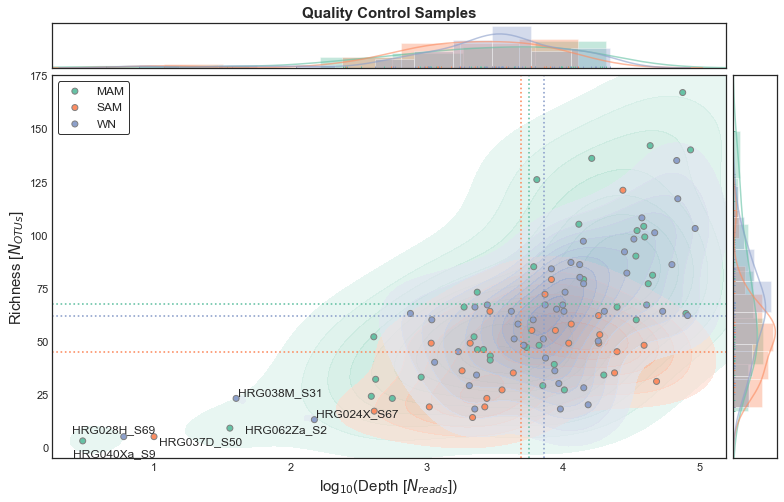

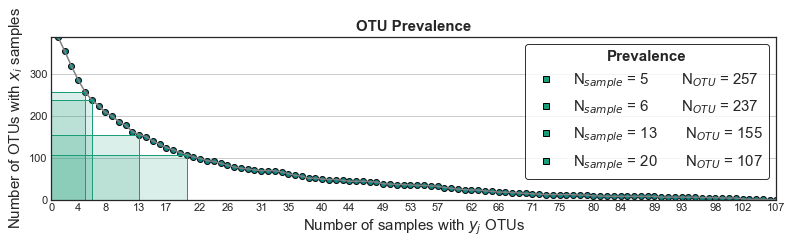

In [5]:
# Removing low quality samples
idx_samples_poorqc = ds_otus[None].sum(axis=1).sort_values().index[:6] # ds_otus[None] is the original counts table used to build the Dataset
sy.visuals.plot_compositional(X=ds_otus[None], y=ds_otus.y, class_colors=colors_status.class_colors, show_annotations=idx_samples_poorqc, attr_type="OTU", show_ygrid=False, style="seaborn-white", background_color="white", title="Quality Control Samples")

# Add versions
# QC of samples
ds_otus.add_version("QC(samples)", ds_otus[None].drop(idx_samples_poorqc))
# QC of samples, remove OTUS in fewer than 13 samples
ds_otus.add_version(("QC(samples)", ("prevalence",13)), data=sy.utils.filter_compositional(ds_otus["QC(samples)"], tol_prevalence=13))
# QC of samples, remove OTUS in fewer than 13 samples, CLR normalization
ds_otus.add_version(("QC(samples)", ("prevalence",13),  "clr"), data=sy.transmute.transform_clr(ds_otus[("QC(samples)", ("prevalence",13))]))
# QC of samples, remove OTUS in fewer than 13 samples, CLR normalization, Z-score normalization for multimodal associations
ds_otus.add_version(("QC(samples)", ("prevalence",13),  "clr", "zscore"), data=sy.transmute.normalize(ds_otus[("QC(samples)", ("prevalence",13),  "clr")], "zscore", axis=0))
# Set default version
ds_otus.set_default(("QC(samples)", ("prevalence", 13)))

# Counts of OTUs at various taxonomy levels
taxonomy_counts = dict()
taxonomy_counts["OTU"] = ds_otus["QC(samples)"]
taxonomy_counts.update(dict(map(lambda x: (x, taxonomy_counts["OTU"].groupby(ds_otus.metadata_attributes[x], axis=1).sum()), ['Life', 'Domain', 'Phylum', 'Class', 'Order', 'Family', 'Genus', 'Species'])))
print(*map(lambda x: "{} {}".format(x[0], x[1].shape), taxonomy_counts.items()), sep=" | ")

# Prevalence of OTUs
sy.visuals.plot_prevalence(taxonomy_counts["OTU"], attr_type="OTU", obsv_type="sample", title="OTU Prevalence", show_prevalence=[5,6,13, 20], figsize=(13,3), title_kws={"fontsize":15})

# Reset the colors
colors_status = sy.Chromatic.from_classes(df_meta_samples.drop(idx_samples_poorqc)["Nutritional_Status"], name="Nutritional_Status", class_type="status", obsv_type="sample", palette="Set2")

print("Current default: {} {}".format(ds_otus.X_version, ds_otus.X.shape))


## Cycle thresholds [16S Amplicons]

MAM 23.44796884059906
SAM 29.346520233154298
WN 26.252043516739555


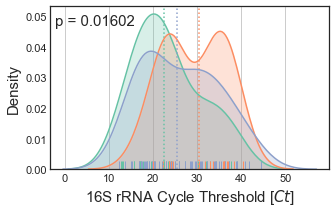

In [6]:
# df_loadings = sy.io.read_dataframe("../../../../GambiaGut/Data/metadata/TAC_Malnutrition project_CTs.xlsx", index_col=None)["Raw data"]
# df_loadings = df_loadings.iloc[:,:10]
# df_loadings.columns = ["SubjectID"] + df_loadings.columns[1:].tolist()
# df_loadings["Date_Collected"] = df_loadings["Date collected"].map(pd.Timestamp)
# df_loadings = df_loadings.loc[df_loadings["16S"][lambda x: x != "U"].dropna().index]
# df_loadings = df_loadings.loc[df_loadings["SubjectID"].map(lambda x: not x.startswith(("Blank","NFW")))]
# df_loadings["Visit[Day]"] = df_loadings["Day"].astype(int)
# df_loadings = df_loadings.set_index(["SubjectID", "Visit[Day]"]).sort_index()


# decode = dict()
# for i, data in df_meta_samples.reset_index().iterrows():
#     decode[(data["SubjectID"], data["Visit[Day]"])] = data[0]

# df_loadings = sy.io.read_dataframe("./Data/cycle_thresholds.16s.tsv", index_col=[0,1])
    
# ct_16s = dict()
# for (subject, day), ct_values in df_loadings["16S[Ct]"].groupby(lambda x:x):
#     id = (subject,day)
#     if id in decode:
#         id = decode[id]
#         ct_16s[id] = np.mean(ct_values)
# ct_16s = pd.Series(ct_16s)

# Cycle thresholds
ct_16s = sy.io.read_dataframe("./Data/cycle_thresholds.16s.tsv")["16S[Ct]"]
with plt.style.context("seaborn-white"):
    fig, ax = plt.subplots(figsize=(5,3))
    data = list()
    for id_status, u in ct_16s.groupby(ds_otus.y):
        sns.distplot(u, color=colors_status.class_colors[id_status], rug=True, ax=ax, kde_kws={"shade":True}, hist=False)#, label="µ = %0.3f"%u.median())
        ax.axvline(u.median(), color=colors_status.class_colors[id_status], linestyle=":")
        ax.set_xlabel("16S rRNA Cycle Threshold [$Ct$]", fontsize=15)
        ax.set_ylabel("Density", fontsize=15)
        ax.xaxis.grid(True)
        data.append(u)
        print(id_status, u.mean())
    stat, p = stats.kruskal(*data)

    ax.text(min(ax.get_xlim())+1, max(ax.get_ylim())*0.95, "p = %0.5f"%p, ha="left", va="top", fontsize=15)
#     ax.legend(*sy.utils.format_mpl_legend_handles(colors_status.class_colors[["WN", "MAM", "SAM"]]), markerscale=2, **sy.utils.LEGEND_KWS)



## Alpha diversity analysis (Richness)

<ipython-input-2-f2446f3c2f6f>:116: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticks(), **ytick_kws)
<ipython-input-7-15f30dadf046>:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_yticklabels(list(map(lambda y:str(float(eval(y.get_text()))).split(".")[0], axes[i].get_yticklabels()))) #! I hate this
<ipython-input-2-f2446f3c2f6f>:116: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticks(), **ytick_kws)
<ipython-input-7-15f30dadf046>:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_yticklabels(list(map(lambda y:str(float(eval(y.get_text()))).split(".")[0], axes[i].get_yticklabels()))) #! I hate this
<ipython-input-2-f2446f3c2f6f>:116: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticks(), **ytick_kws)
<ipython-input-7-15f30dadf

WN      706.539315
MAM    1458.357983
SAM     547.423333
dtype: float64

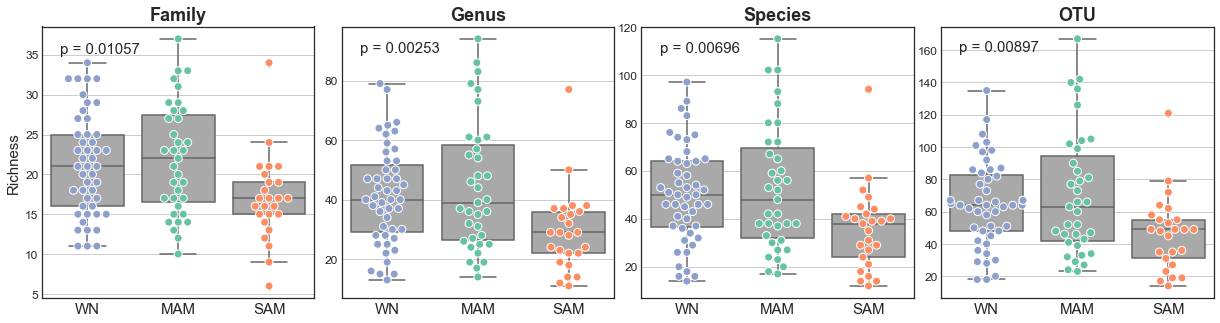

In [7]:
# Alpha diversity
df_richness = sy.microbiome.alpha_diversity(X=ds_otus["QC(samples)"], taxonomy=ds_otus.metadata_attributes, obsv_type="patient", metric="richness")
df_richness.columns = df_richness.columns[:-1].tolist() + ["OTU"]

# Get groupings by taxonomy
data = list()
for id_class, df in df_richness.groupby(ds_otus.y):
    df = df.loc[:,["Family", "Genus", "Species", "OTU"]]
    df.columns = df.columns.map(lambda x: ( x, id_class))
    data.append(df.reset_index(drop=True))

# Plot richness for various taxonomy levels
df_richness_grouped = pd.concat(data, axis=1).sort_index(axis=1)
df_richness_grouped = df_richness_grouped[[*itertools.product(["Family", "Genus", "Species", "OTU"], ["WN", "MAM", "SAM"])]]
with plt.style.context("seaborn-white"):
    fig, axes = plt.subplots(figsize=(21,5), ncols=4, sharey=False, gridspec_kw=dict(wspace=0.1,  hspace=0))
    for id_taxon, df in df_richness_grouped.groupby(lambda x:x[0], axis=1):
        df.columns = df.columns.droplevel(0)
        i = dict(zip(["OTU", "Species", "Genus", "Family"][::-1], range(4)))[id_taxon]
        ax = plot_distribution(df, ylabel={True:"Richness", False:None}[i == 0], title=id_taxon, ax=axes[i], color_swarm=df.columns.map(lambda x:colors_status.class_colors[x]), swarm_kws={"edgecolor":"white"}, x_rot=0, figsize=(21,5)) 
        axes[i].set_yticklabels(list(map(lambda y:str(float(eval(y.get_text()))).split(".")[0], axes[i].get_yticklabels()))) #! I hate this
        axes[i].yaxis.grid(True)
        stat, p = stats.kruskal(df["WN"].dropna(), df["MAM"].dropna(), df["SAM"].dropna())
        axes[i].text(-0.3, max(axes[i].get_ylim())*0.95, "p = %0.5f"%p, ha="left", va="top", fontsize=15)
        
# # Only plot OTU level
#     fig, ax = plt.subplots(figsize=(5,5), ncols=1, sharey=False, gridspec_kw=dict(wspace=0.1,  hspace=0))
#     df = df_richness_grouped["OTU"]
#     ax = plot_distribution(df, ylabel="Richness(OTU)", ax=ax, color_swarm=df.columns.map(lambda x:colors_status.class_colors[x]), swarm_kws={"edgecolor":"white"}, x_rot=0, figsize=(21,5)) 
#     ax.set_yticklabels(list(map(lambda y:str(float(eval(y.get_text()))).split(".")[0], ax.get_yticklabels()))) 
#     ax.yaxis.grid(True)
#     stat, p = stats.kruskal(df["WN"].dropna(), df["MAM"].dropna(), df["SAM"].dropna())
#     ax.text(-0.3, max(ax.get_ylim())*0.95, "p = %0.5f"%p, ha="left", va="top", fontsize=15)

df_richness_grouped["OTU"].var(axis=0)

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


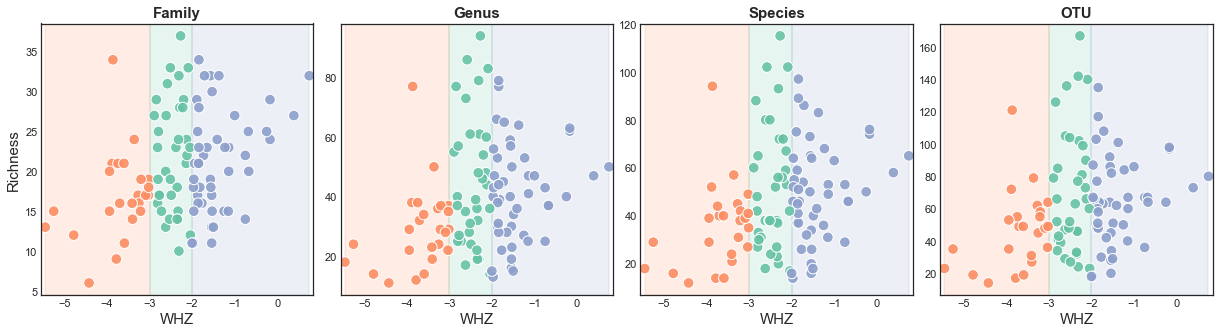

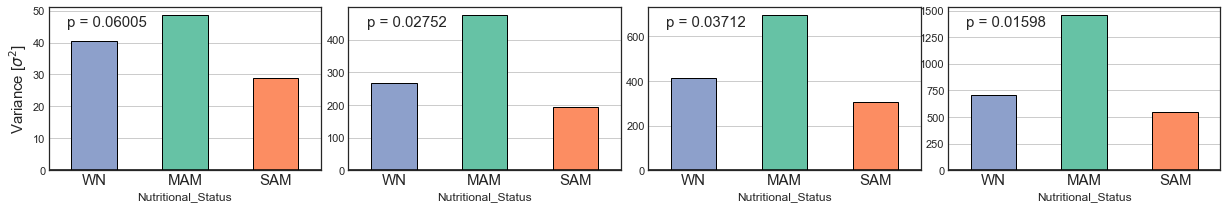

In [8]:
# Plotting WHZ and Richness
with plt.style.context("seaborn-white"):
    # WHZ vs. Richness
    fig, axes = plt.subplots(figsize=(21,5), ncols=4, sharex=True, sharey=False, gridspec_kw=dict(wspace=0.1, hspace=0))
    for i, id_taxon in enumerate(["Family", "Genus", "Species", "OTU"]):
        df = pd.concat([df_meta_samples.loc[df_richness.index,"WHZ"].to_frame(), df_richness[id_taxon].to_frame()], axis=1)
        sy.visuals.plot_scatter(data=df,c=colors_status.obsv_colors, ax=axes[i], title=id_taxon, xlabel="WHZ", ylabel={True:"Richness", False:None}[i==0])
        axes[i].legend(fontsize=15)
        xlim = axes[i].get_xlim()
        ylim = axes[i].get_ylim()
        axes[i].fill_between([df["WHZ"].min(), -3], *ylim, color=colors_status.class_colors["SAM"], linestyle="-", linewidth=1.618, alpha=0.1618, zorder=0)
        axes[i].fill_between([-3, -2], *ylim, color=colors_status.class_colors["MAM"], linestyle="-", linewidth=1.618, alpha=0.1618, zorder=0)
        axes[i].fill_between([-2, df["WHZ"].max()], *ylim, color=colors_status.class_colors["WN"], linestyle="-", linewidth=1.618, alpha=0.1618, zorder=0)
        axes[i].set_xlim(xlim)
        axes[i].set_ylim(ylim)
        pad = 0.1
        axes[i].set_xlim((df["WHZ"].min()-pad, df["WHZ"].max()+pad))
        
    # Variance
    fig, axes = plt.subplots(figsize=(21,3), ncols=4, sharex=True, sharey=False, gridspec_kw=dict(wspace=0.1, hspace=0))
    for i, id_taxon in enumerate(["Family", "Genus", "Species", "OTU"]):
        df = pd.concat([df_meta_samples.loc[df_richness.index,"WHZ"].to_frame(), df_richness[id_taxon].to_frame()], axis=1)
        axes[i].axhline(0, color="black")
        if i == 0:
            axes[i].set_ylabel("Variance [$σ^2$]", fontsize=15)
        df[id_taxon].groupby(ds_otus.y).var()[["WN", "MAM", "SAM"]].plot(kind="bar", ax=axes[i],color=colors_status.class_colors[["WN", "MAM", "SAM"]], edgecolor="black")
        axes[i].set_xticklabels(axes[i].get_xticklabels(), fontsize=15, rotation=0)
        axes[i].yaxis.grid(True)

        
        stat, p = stats.levene(*map(lambda x:x[1].dropna().values, df[id_taxon].groupby(ds_otus.y)))
        axes[i].text(-0.3, max(axes[i].get_ylim())*0.95, "p = %0.5f"%p, ha="left", va="top", fontsize=15)


## Relative abundance of Family-level taxonomy

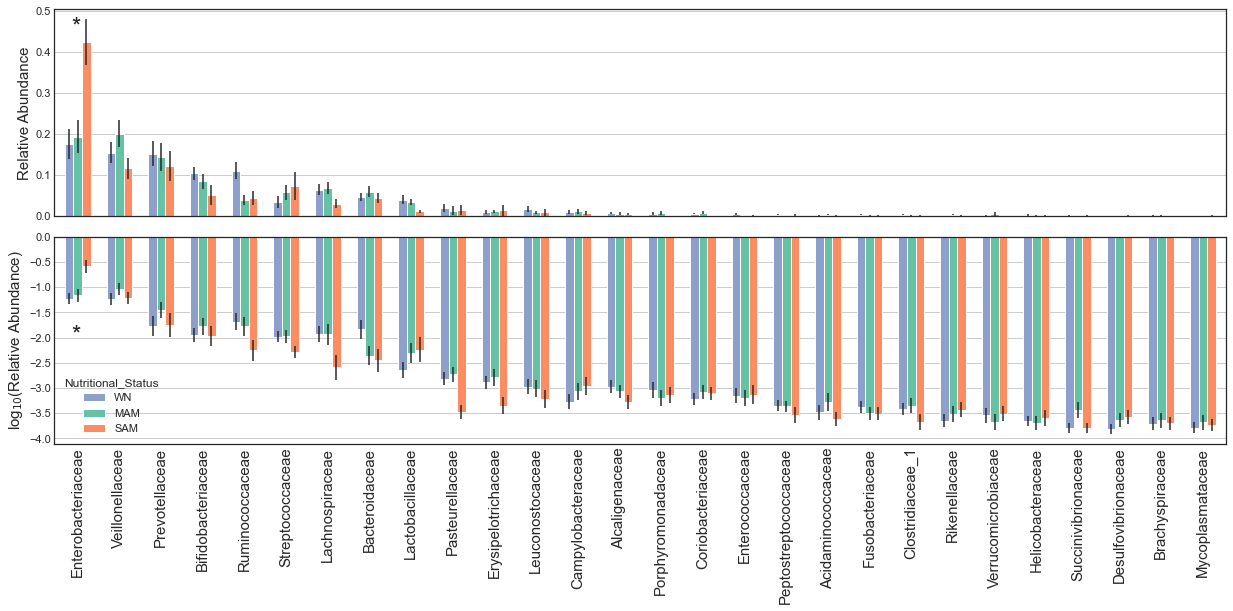

In [9]:

with plt.style.context("seaborn-white"):
    fig, axes = plt.subplots(figsize=(21,8), nrows=2, sharex=True, gridspec_kw={"hspace":0.1})
    
    # Linear-scale
    ax = axes[0]
    df = sy.transmute.normalize_tss(taxonomy_counts["Family"]+1)
    
    # Kruskal test
    d_family_p = dict()
    for id_family in df.columns:
        data = dict()
        for k,v in df[id_family].groupby(ds_otus.y):
            data[k] = v
        d_family_p[id_family] = stats.kruskal(*data.values())[-1]
    family_fdr = sy.statistics.p_adjust(pd.Series(d_family_p).sort_values())
#     sns.distplot(df.mean(axis=0))
#     tol = -3.5
    tol = 0.001
    df_linear = df[df.mean(axis=0)[lambda x: x > tol].index]
    µ_linear = df_linear.groupby(ds_otus.y).mean().loc[["WN", "MAM", "SAM"]]
    µ_linear = µ_linear[µ_linear.sum(axis=0).sort_values(ascending=False).index]
    sem_linear = df_linear.groupby(ds_otus.y).sem()[µ_linear.columns]
    µ_linear.T.plot(kind="bar", yerr=sem_linear.T, ax=ax, color=colors_status.class_colors[µ_linear.index], width=0.618)
    
    # Annotations
    for id_family, fdr in family_fdr[lambda x: x < 0.05].iteritems():
        x = {id_family:µ_linear.columns.get_loc(id_family)}
        labels = {id_family:statistically_significant_symbols(fdr)}
        y = {id_family:µ_linear[id_family].max()}
#         plot_annotation(labels=labels,x=x, y=y, ax=ax, x_pad=-0.15,  fontsize=24)
    ax.set_xlabel("")
    ax.set_ylabel("Relative Abundance", fontsize=15)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=15)
    
    ax.legend_ = None
    
    # Log-scale
    ax = axes[1]
    df_log = np.log10(sy.transmute.normalize_tss(taxonomy_counts["Family"]+1)).loc[:,df_linear.columns]

    µ_log = df_log.groupby(ds_otus.y).mean().loc[["WN", "MAM", "SAM"]]
    µ_log = µ_log[µ_log.sum(axis=0).sort_values(ascending=False).index]
    sem_log = df_log.groupby(ds_otus.y).sem()[µ_log.columns]

    µ_log.T.plot(kind="bar", yerr=sem_log.T, ax=ax, color=colors_status.class_colors[µ_log.index], width=0.618)
    ax.set_xlabel("")
    ax.set_ylabel("log$_{10}$(Relative Abundance)", fontsize=15)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=15)
    # Annotations
    for id_family, fdr in family_fdr[lambda x: x < 0.05].iteritems():
        for µ, ax, y_pad in zip([µ_linear, µ_log], axes, [0.25, -1]):
            x = {id_family:µ.columns.get_loc(id_family)}
            labels = {id_family:statistically_significant_symbols(fdr)}
            y = {id_family:µ[id_family].min()}
            sy.visuals.plot_annotation(labels=labels,x=x, y=y, ax=ax, x_pad=-0.15,  y_pad=y_pad, fontsize=24, adjust_label_positions=True)
    for ax in axes:
        ax.yaxis.grid(True)
   


## Beta diversity analysis (Isometric log-ratio using phylogentic tree)

Pruned 233 attributes to match components (X.columns)
Inferred association as `dissimilarity`


(<Figure size 576x576 with 1 Axes>,
 <AxesSubplot:xlabel='PCoA.1(0.1535)', ylabel='PCoA.2(0.07896)'>,
 <matplotlib.collections.PathCollection at 0x7fc626e9a8b0>)

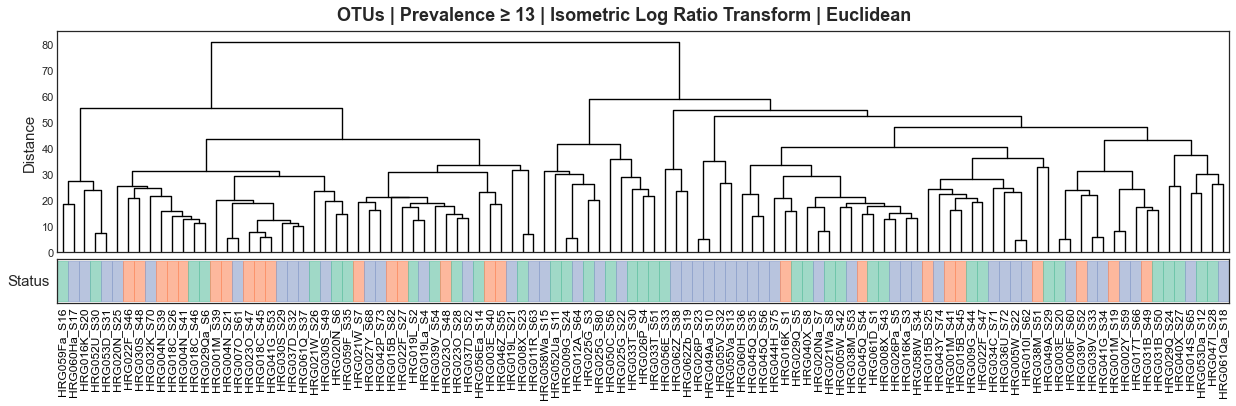

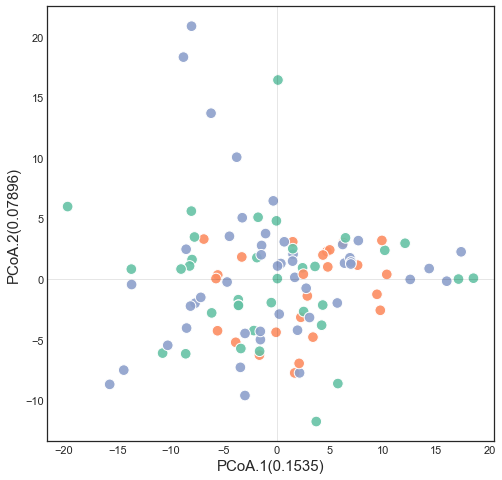

In [10]:
# Isometric log-ratio transform using phylogentic tree
df_ilr = coda.transform_ilr(ds_otus[("QC(samples)", ('prevalence', 13))]+1, tree=tree_16s)

# Pairwise Aitchison distance (Euclidean distance in simplex)
df_dism = sy.symmetry.pairwise(df_ilr, metric="euclidean", axis=0)

# Agglomerative hierarchical clustering
title = "OTUs | Prevalence ≥ 13 | Isometric Log Ratio Transform | Euclidean"
ahc_ilr = sy.Agglomerative(df_dism)
ahc_ilr.add_secondary_class("Status", mapping=ds_otus.y, class_colors=colors_status.class_colors)
ahc_ilr.plot(title=title, show_leaves=True)

# Principal coordinates analysis
sy.ordination.PrincipalCoordinatesAnalysis(df_dism, df_ilr).plot(c=colors_status.obsv_colors)#, show_features=10, arrow_scale=10)

<ipython-input-11-6cfe4792a346>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticks(), fontsize=12)


SAM	p = 4.6888e-19
WN	p = 8.0032e-05
MAM	p = 0.012502
1.4238907404295364e-05


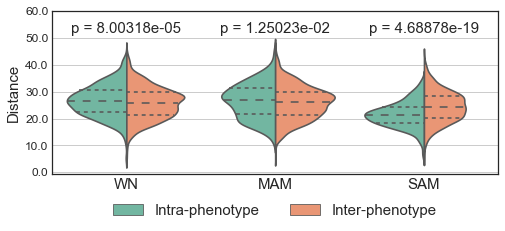

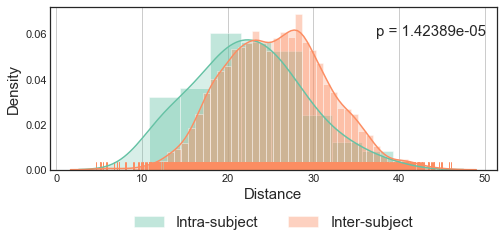

In [11]:
# Intra-inter phenotype beta diversity

# Violinplots
df_beta = sy.microbiome.beta_diversity(df_dism, ds_otus.y, label_intra="Intra-phenotype", label_inter="Inter-phenotype")[["WN", "MAM", "SAM"]]
with plt.style.context("seaborn-white"):
    fig, ax = plt.subplots(figsize=(8,3))
    sns.violinplot(data=pd.melt(df_beta, value_name="Distance"), x="Class", y="Distance", hue="Diversity",  palette="Set2", linewidth=1.618,  split=True, inner="quartile", ax=ax)
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), fancybox=True, shadow=True, ncol=2, fontsize=15)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=15)
    ax.set_yticklabels(ax.get_yticks(), fontsize=12)
    ax.set_xlabel(None)
    ax.set_ylabel(ax.get_ylabel(), fontsize=15)
    ax.yaxis.grid(True)
    for id_class in ds_otus.y.unique():
        u = df_beta[(id_class, "Intra-phenotype")].dropna()
        v = df_beta[(id_class, "Inter-phenotype")].dropna()
        stat, p = stats.mannwhitneyu(u,v)
        print(id_class, "p = {}".format(sy.utils.to_precision( p)), sep="\t")
        ax.text(
            x=df_beta.columns.get_level_values(0).unique().get_loc(id_class), 
            y=ax.get_ylim()[1], 
            s = "p = %0.5e"%p,
            ha="center",
            fontsize=15)
    ax.set_ylim(ax.get_ylim()[0], ax.get_ylim()[1] + 8)
    
# KDE plots
df_beta = sy.microbiome.beta_diversity(df_dism, ds_otus.metadata_observations["SubjectID"])
df_melt = pd.melt(df_beta, value_name="Distance").dropna(how="any", axis=0)
with plt.style.context("seaborn-white"):
    fig, ax = plt.subplots(figsize=(8,3))
    u = df_melt.query("Diversity == 'Intra'")["Distance"]
    v = df_melt.query("Diversity == 'Inter'")["Distance"]
    sns.distplot(u, color=sns.color_palette("Set2", n_colors=2)[0], ax=ax, rug=True, kde_kws=dict(shade=True), label="Intra-subject")
    sns.distplot(v, color=sns.color_palette("Set2", n_colors=2)[1], ax=ax, rug=True, kde_kws=dict(shade=True), label="Inter-subject")
    ax.xaxis.grid(True)
    stat, p = stats.mannwhitneyu(u,v)
    ax.text(ax.get_xlim()[1]*0.85, ax.get_ylim()[1]*0.85, s="p = %0.5e"%(p), ha="center", va="center", fontsize=15)
    ax.set_xlabel("Distance", fontsize=15)
    ax.set_ylabel("Density", fontsize=15)
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), fancybox=True, shadow=True, ncol=2, fontsize=15)
    print(p)



## Clinical measurements

In [12]:
# Load clinical data
ds_clinicals = sy.Dataset(
    data="./Data/clinical_measurements.tsv.gz",
    metadata_observations=df_meta_samples,
    metadata_target_field="Nutritional_Status",
    name="Clinicals",
    obsv_type="sample",
    attr_type="clinical_measurement",
    metric_type="measurements",
)

# Aggregate pre/post measurements
clinicals_prepost = ["sobr", "leptin", "ghrp", "ghrelin", "molar", "igf1", "igfbp3", "igfbp3", "molarigf1igfbp3"]
clinicals_singular = ['insulin', 'cpeptide', 'salivarycrp', 'cortisol']
idx_clinicals = clinicals_prepost + clinicals_singular
data_clinicals = dict()
for suffix in clinicals_prepost:
    data = ds_clinicals[None].loc[:,["pre{}".format(suffix), "post{}".format(suffix)]]
    data_clinicals[suffix] = data.mean(axis=1)
    
# Add version
ds_clinicals.add_version("aggregated", pd.concat([pd.DataFrame(data_clinicals), ds_clinicals[None][clinicals_singular]], axis=1))
ds_clinicals.add_version(("aggregated","zscore"), sy.transmute.normalize(ds_clinicals["aggregated"], "zscore", axis=0))

Dataset| Clinicals | (107, 20)
        obsv_type: sample
        attr_type: clinical_measurement
        metric_type: measurements
        description: None
datasets: [None, 'aggregated', ('aggregated', 'zscore')]
attribute_subsets: [None]
observation_subsets: [None]
        metadata_observations: 13
        metadata_attributes: 0
        default: None | (107, 20)
        2020-08-16 21:22:14

## Pathogen markers

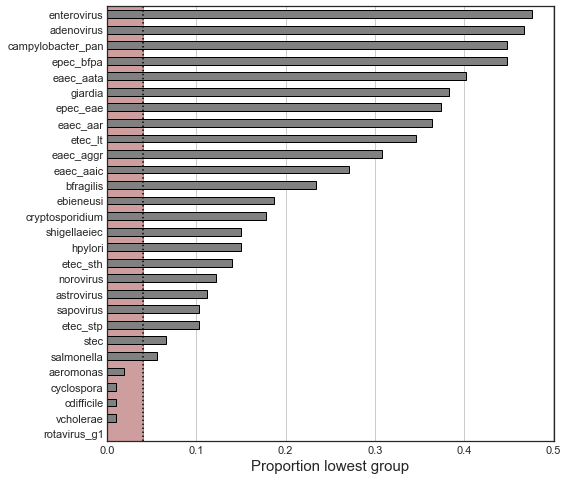

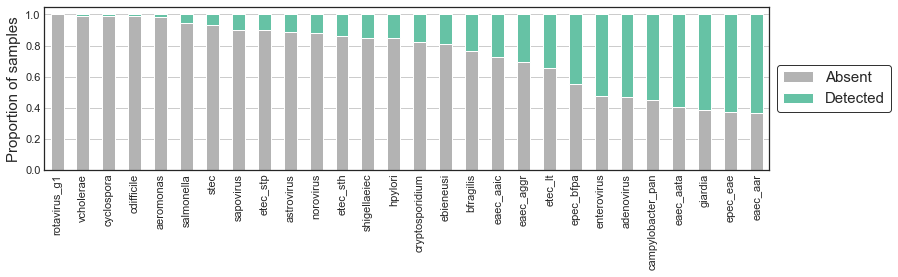

In [13]:
# Load pathogen data
ds_pathogens = sy.Dataset(
    data="./Data/pathogen_markers.tsv.gz",
    metadata_observations=df_meta_samples,
    metadata_target_field="Nutritional_Status",
    name="Pathogens",
    obsv_type="sample",
    attr_type="pathogen",
    metric_type="presence",
)

# Aggregating nested pathogens
aggregate = sy.utils.dict_build([
    ("adenovirus", ["adenovirus_f", "adenovirus_pan"]), # v6 only remove adenovirus_pan
    ("cryptosporidium", ["cryptosporidium", "cryptosporidium_hominis", "cryptosporidium_parvum"]), 
#     ("eaec", ["eaec_aaic", "eaec_aar", "eaec_aata", "eaec_aggr"]),
#     ("epec", ["epec_bfpa", "epec_eae", "etec_lt", "etec_sth", "etec_stp"]),
    ("giardia", ["giardia", "giardia_a", "giardia_b"]), # v6 only remove giardia
    ("norovirus", ["norovirusgi", "norovirusgii"]), 
    ("stec", ["stec_stx1", "stec_stx2"]),
])

ds_pathogens.add_version("aggregated", ds_pathogens[None].groupby(lambda x: aggregate[x] if x in aggregate else x, axis=1).sum().astype(bool).astype(int))

# Filtering pathogen markers
tol_homogeneity = 0.04
pathogen_min_proportion = sy.transmute.normalize(ds_pathogens["aggregated"].apply(lambda x:x.value_counts(), axis=0).fillna(0).astype(int).T).min(axis=1).sort_values()
with plt.style.context("seaborn-white"):
    fig, ax = plt.subplots(figsize=(8,8))
    pathogen_min_proportion.plot(kind="barh", ax=ax, color="gray", edgecolor="black")
    ax.xaxis.grid(True)
    ax.set_xlabel("Proportion lowest group", fontsize=15)
    ax.axvline(tol_homogeneity, color="black", linestyle=":")
    ax.fill_between([0,tol_homogeneity], *ax.get_ylim(), color="maroon", alpha=0.382)
idx_pathogens_pass_qc = pathogen_min_proportion[lambda x: x > tol_homogeneity].index

# Add version
ds_pathogens.add_version(("aggregated","tol > {}".format(tol_homogeneity)), ds_pathogens["aggregated"].loc[:,idx_pathogens_pass_qc].groupby(lambda x: aggregate[x] if x in aggregate else x, axis=1).sum().astype(bool).astype(int))

# Plot presence vs. absence
df = sy.transmute.normalize(ds_pathogens["aggregated"].apply(lambda x:x.value_counts(), axis=0).fillna(0).astype(int).T)
df.columns = ["Absent", "Detected"]
with plt.style.context("seaborn-white"):
    fig, ax = plt.subplots(figsize=(13,3))
    df.sort_values("Detected").plot(kind="bar", stacked=True, ax=ax, cmap="Set2_r")
    ax.legend(**sy.utils.LEGEND_KWS)
    ax.set_ylabel("Proportion of samples", fontsize=15)
    ax.yaxis.grid(True)

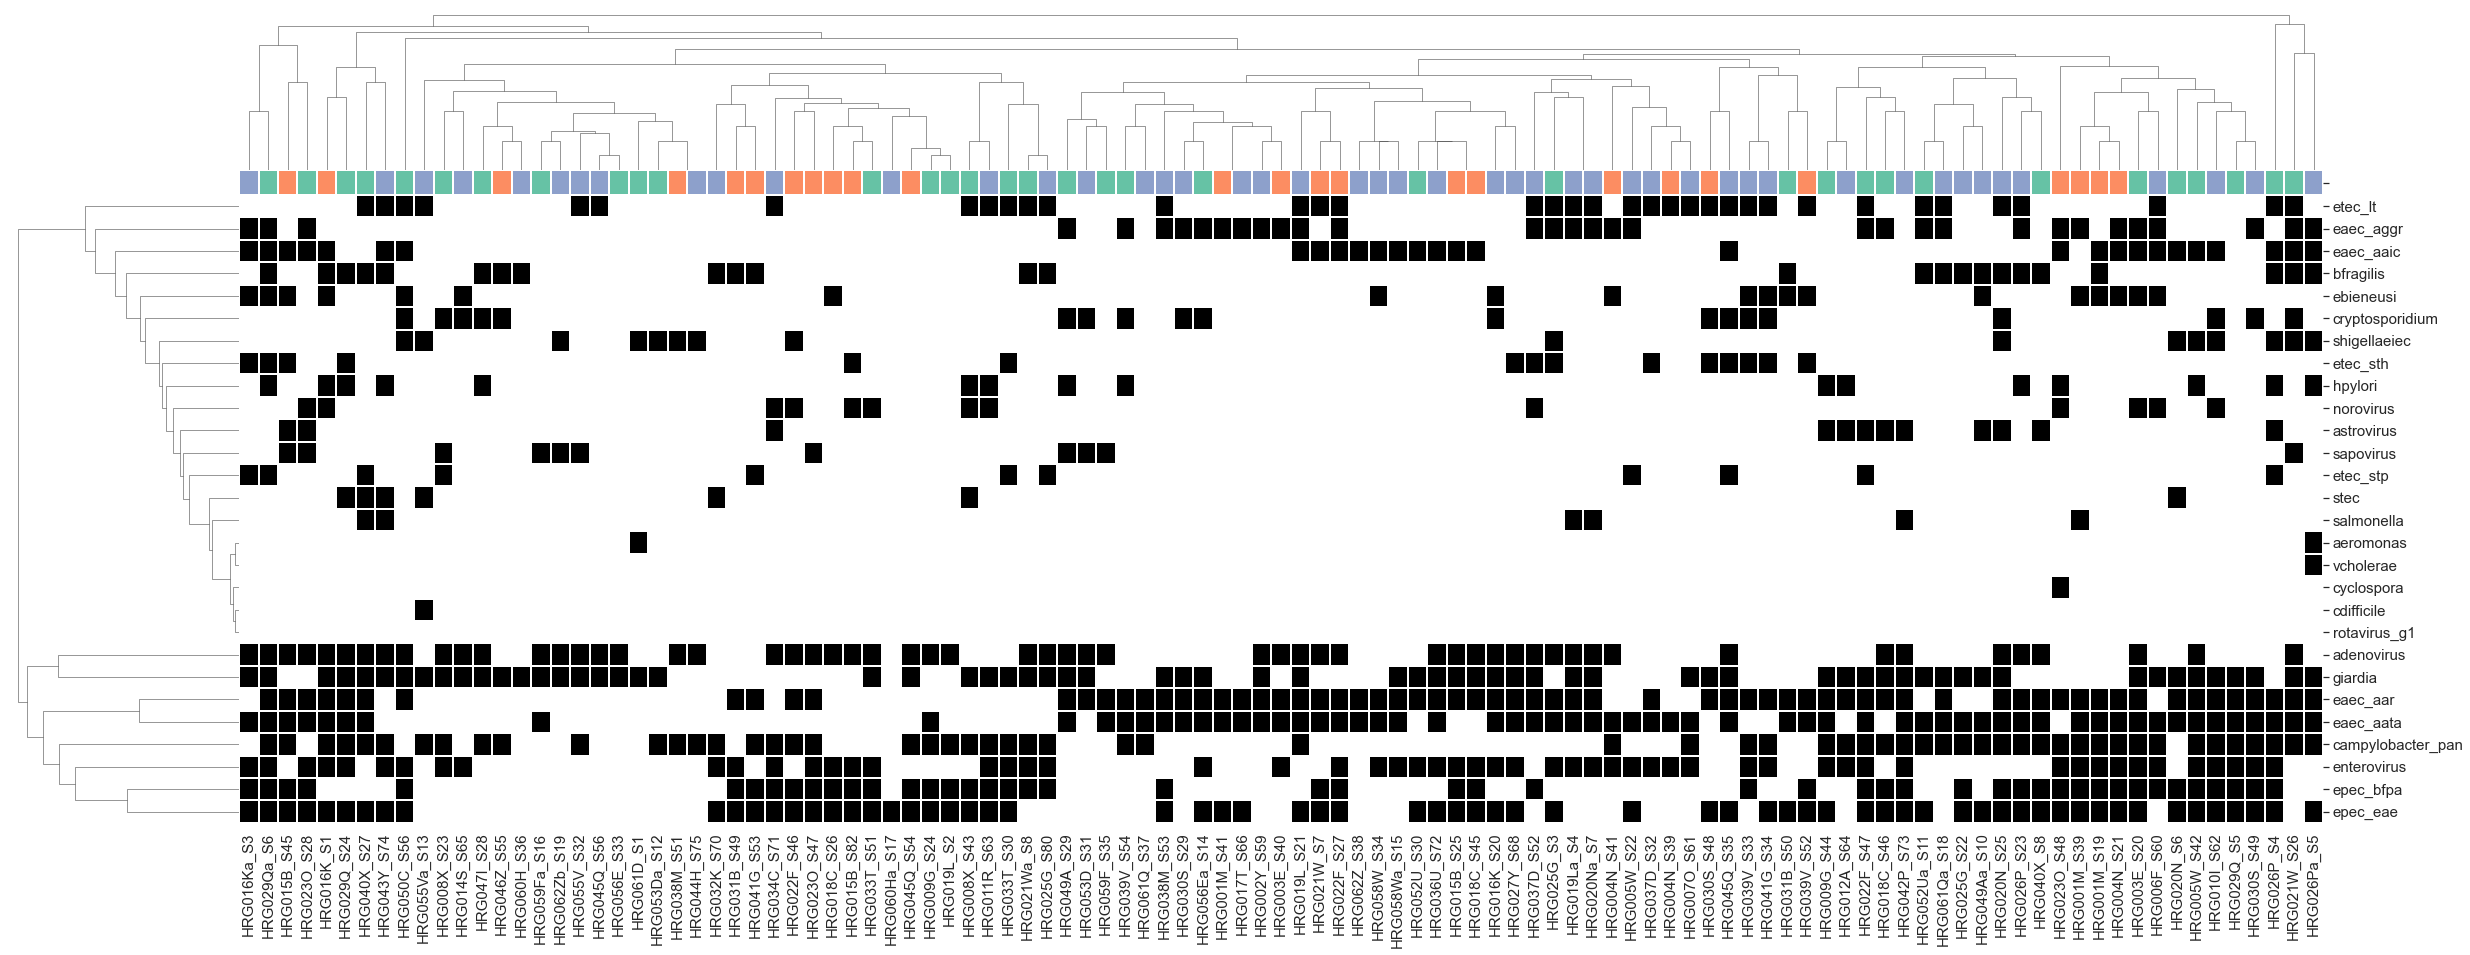

In [14]:
# Cluster samples based on pathogen markers
df = ds_pathogens["aggregated"].T
g = sns.clustermap(df, metric="hamming", method="average", cmap="gray_r", figsize=(34,13), edgecolor="white", linewidth=1, col_colors=colors_status.obsv_colors[df.columns], dendrogram_ratio=(0.1, 0.2))#, mask=df_pathogens == 0)
g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xticklabels(), fontsize=15)#, fontweight="bold")
g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_yticklabels(), fontsize=15)#, fontweight="bold")
# g.ax_heatmap.set_facecolor("gray")
g.cax.set_visible(False)

## Multimodal dataset

In [15]:
# Merge datasets
df = pd.concat([
    ds_otus[('QC(samples)', ("prevalence",13),  "clr", "zscore")],
    ds_clinicals[('aggregated', 'zscore')],
    ds_pathogens[("aggregated", "tol > {}".format(tol_homogeneity))],
    
], axis=1)

# Nodes
ds_multimodal = sy.Dataset(
    data=df, 
    name="Nodes", 
    obsv_type="sample",
    attr_type="multimodal",
    metadata_observations=df_meta_samples,
    metadata_target_field="Nutritional_Status",
)

# Mapping
y_modality = sy.utils.dict_build([
    ("microbiome", ds_otus[('QC(samples)', ("prevalence",13),  "clr", "zscore")]), 
    ("clinical", ds_clinicals[('aggregated', 'zscore')]), 
    ("pathogen", ds_pathogens[("aggregated", "tol > {}".format(tol_homogeneity))])], 
    into=pd.Series,
)

# Colors
colors_modality = sy.Chromatic.from_classes(y_modality, palette=sns.color_palette(palette=['#bebada', '#8dd3c7', '#fb8072']))

ds_multimodal

Dataset| Nodes | (107, 190)
        obsv_type: sample
        attr_type: multimodal
        metric_type: None
        description: None
datasets: [None]
attribute_subsets: [None]
observation_subsets: [None]
        metadata_observations: 13
        metadata_attributes: 0
        default: None | (107, 190)
        2020-08-16 21:22:19

## Linear mixed-effects models

Dataset| Nodes | (107, 190)
        obsv_type: sample
        attr_type: multimodal
        metric_type: None
        description: None
datasets: [None, 'residuals']
attribute_subsets: [None]
observation_subsets: [None]
        metadata_observations: 13
        metadata_attributes: 0
        default: None | (107, 190)
        2020-08-16 21:22:19

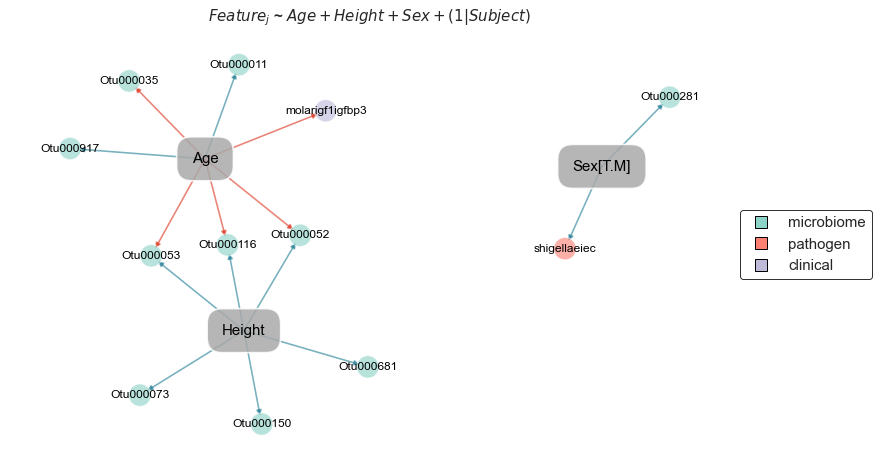

In [16]:
# MixedLM
df_design = df_meta_samples.loc[ds_multimodal[None].index, ["Sex", "SubjectID", "Height", "Age[Days]"]]
df_design.columns = ["Sex", "SubjectID", "Height", "Age"]
for id_field in ["Height", "Age"]:
    df_design[id_field] = sy.transmute.normalize_zscore(df_design[id_field])
    
# # Multiple regression
# with warnings.catch_warnings():
#     warnings.simplefilter("ignore")
#     mixedlm = sy.regression.MixedEffectsLinearModel(name="Multimodal", attr_type="multimodal", obsv_type="sample")
#     mixedlm.fit(X=ds_multimodal[None], Y=df_design, random_effect_variable="SubjectID", fixed_effects_variables=["Sex", "Age", "Height"], assert_missing_values=False)
# mixedlm.create_graph()
# mixedlm.to_file("./Data/mixedlm.multimodal__fixed_age-sex-height__random_subject.pkl")

# Load MixedLMs
mixedlm = sy.io.read_object("./Data/mixedlm.multimodal__fixed_age-sex-height__random_subject.pkl")
mixedlm.plot_graph(title = "$Feature_j$ ~ $Age + Height + Sex + (1|Subject)$", node_colors=colors_modality.obsv_colors, show_node_labels=True, legend=colors_modality.class_colors[colors_modality.y[set(mixedlm.graph.nodes()) & set(colors_modality.y.index)].unique()])

# Update dataset
ds_multimodal.add_version("residuals", mixedlm.residuals_.loc[ds_multimodal.index])

## Sample-specific perturbation networks

In [17]:
# Data
X_features = ds_multimodal["residuals"]

# Getting reference WN cohort
d_subject_type = dict()
d_type_visits = defaultdict(list)
for id_subject, visits in sy.utils.pd_series_collapse(ds_multimodal.metadata_observations.loc[X_features.index,"SubjectID"], type_collection=pd.Index).items():
    y_phenotype = ds_multimodal.y[visits]
    if np.all(y_phenotype == "WN"):
        d_subject_type[id_subject] = "reference"
        d_type_visits["reference"] += visits.tolist()
    else:
        d_subject_type[id_subject] = "query"
        d_type_visits["query"] += visits.tolist()

# Set reference status
reference_label = "WN_"
y = ds_multimodal.y[X_features.index]
y[d_type_visits["reference"]] = reference_label

# Subset samples
reference_visits = y[lambda x: y == reference_label].index
query_visits = y[lambda x: y != reference_label].index
reference_visits.size, query_visits.size

# Update target nutritional status
ds_multimodal.metadata_observations["SSPN_Status"] = y
ds_multimodal.set_metadata_target("SSPN_Status")

Dataset| Nodes | (107, 190)
        obsv_type: sample
        attr_type: multimodal
        metric_type: None
        description: None
datasets: [None, 'residuals']
attribute_subsets: [None]
observation_subsets: [None]
        metadata_observations: 13
        metadata_attributes: 0
        default: None | (107, 190)
        2020-08-16 21:22:19

In [18]:
# Sample-specific networks
t=time.time()
sspn = enx.SampleSpecificPerturbationNetwork(name="v5", node_type="multimodal", edge_type="correlation", observation_type="visit", assert_symmetry=False)
sspn.fit(
    X=ds_multimodal["residuals"], 
    y=ds_multimodal.y, 
    reference="WN_", 
    metric="pearson", 
    stats_summary=[np.nanmean], 
    stats_tests=None, 
    stats_summary_initial=[np.nanmean], 
    copy_ensemble=True,
)

# Compare SSN to reference
µ_reference = sspn.ensemble_reference_.stats_["nanmean"]
µ_query = pd.DataFrame({id_sample:sspn.ensembles_samplespecific_[id_sample].stats_["nanmean"] for id_sample in sspn.ensembles_samplespecific_}).T
X_edges = µ_query - µ_reference

# Remove edges that are empty
idx_edges_empty = (X_edges == 0).sum(axis=0)[lambda x: x == X_edges.shape[0]].index
X_edges = X_edges.drop(idx_edges_empty, axis=1).dropna(how="any", axis=1)

# Duration
print("SSPN Duration: {}".format(sy.utils.format_duration(t)))

Computing summary statistics (WN_):   0%|          | 0/1 [00:00<?, ? stats/s]/Users/jespinoz/anaconda3/envs/soothsayer5_env/lib/python3.8/site-packages/ensemble_networkx/ensemble_networkx.py:438: RuntimeWarning: Mean of empty slice
  self.stats_[:,k] = func(values, axis=0)
Computing summary statistics (WN_): 100%|██████████| 1/1 [00:00<00:00,  5.83 stats/s]
Computing sample-specific perturbation networks: 0 samples [00:00, ? samples/s]/Users/jespinoz/anaconda3/envs/soothsayer5_env/lib/python3.8/site-packages/ensemble_networkx/ensemble_networkx.py:813: RuntimeWarning: Mean of empty slice
  self.stats_[i,:,k] = func(values_perturbation, axis=0)
Computing sample-specific perturbation networks: 82 samples [04:12,  3.09s/ samples]


SSPN Duration: 00:04:23


## Set up SSPN matrix

In [19]:
# Create dataset for perturbation profiles
index = sy.io.read_object("./Data/sspn.index.list.pkl") # Match the index of when it was initially run
columns = sy.io.read_object("./Data/sspn.columns.list.pkl") # Match the index of when it was initially run

ds_perturbations = sy.Dataset(
    data=X_edges.loc[index, columns],
    metadata_observations=df_meta_samples.loc[index],
    metadata_target_field="Nutritional_Status",
    name="perturbation_matrix",
    obsv_type="sample",
    attr_type="edge",
    metric_type="perturbation",
)

# View the dataset
ds_perturbations

Dataset| perturbation_matrix | (82, 14270)
        obsv_type: sample
        attr_type: edge
        metric_type: perturbation
        description: None
datasets: [None]
attribute_subsets: [None]
observation_subsets: [None]
        metadata_observations: 13
        metadata_attributes: 0
        default: None | (82, 14270)
        2020-08-16 21:26:46

Inferred association as `dissimilarity`


(<Figure size 1512x360 with 3 Axes>,
 [<AxesSubplot:ylabel='Distance'>,
  <matplotlib.axes._axes.Axes at 0x7fc62888d070>])

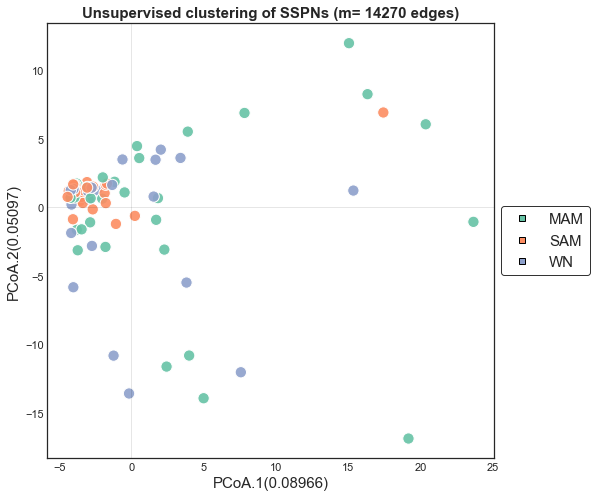

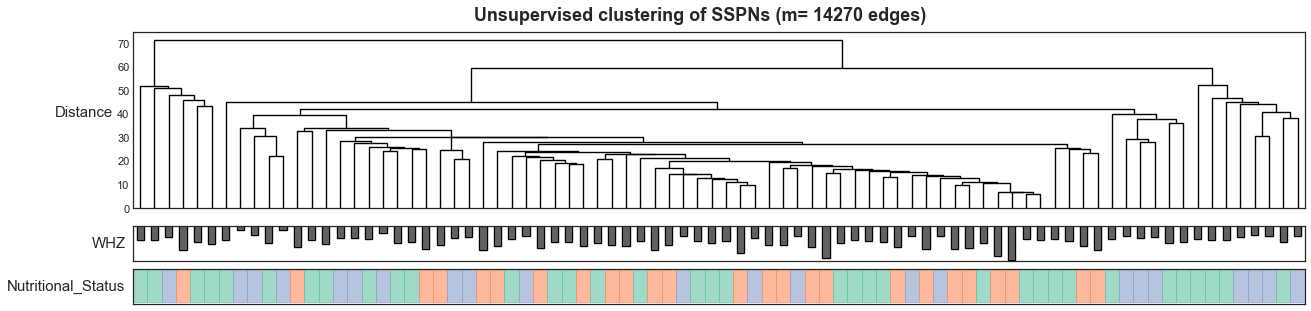

In [20]:
# Let's check the clustering based on the perturbation profiles

# Pairwise Euclidean distance of the perturbations
df_dism = sy.symmetry.pairwise(ds_perturbations.X, metric="euclidean", axis=0)

# PCoA
title="Unsupervised clustering of SSPNs (m= {} edges)".format(ds_perturbations.X.shape[1])
sy.ordination.PrincipalCoordinatesAnalysis(dism=df_dism).plot( c=colors_status.obsv_colors, title=title, legend=colors_status.class_colors)

# Hierarchical clustering
ahc = sy.Agglomerative(df_dism)
ahc.add_secondary_class("Nutritional_Status", y[df_dism.index], class_colors=colors_status.class_colors)
ahc.add_track("WHZ", ds_perturbations.metadata_observations["WHZ"])
ahc.plot(title=title)

# Spoiler alert, doesn't look very good but just wait...

## Leveraging *Clairvoyance* feature selection for phenotype-discriminative community detection

Running computational pipeline:
eigendecomposition	00:00:00
dissimilarity	00:00:00
cluster	00:00:00
dendrogram	00:00:00
convert_to_tree	00:00:00
convert_to_graph	00:00:00


Inferred association as `dissimilarity`


Text(0.5, 0, 'Nutritional Status')

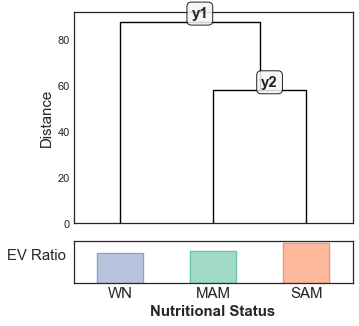

In [21]:
# Determine data-driven hierarchical structure 
topology = sy.Topology(ds_perturbations.X.copy(), ds_perturbations.y.copy(), class_type="status", obsv_type="perturbation", attr_type="edge", class_colors=colors_status.class_colors) #ds_perturbations.X is equivalent to ds_perturbations[None] because theres only one version
fig, _ = topology.plot_topology(figsize=(5,5))
fig.axes[-1].set_xlabel("Nutritional Status", fontsize=15, fontweight="bold")

In [22]:
# Set up directories for running Clairvoyance feature selection
submodel_data = defaultdict(dict)
for submodel, y_submodel in topology.get_target_matrix().T.iterrows():
    y_submodel = y_submodel.dropna()
    X_submodel = ds_perturbations.X.loc[y_submodel.index]
    subjects = sorted(ds_perturbations.metadata_observations.loc[X_submodel.index, "SubjectID"].unique())
    
    # Get LSOCV pairs
    cv_pairs = defaultdict(dict)
    for id_subject in subjects:
        mask = X_submodel.index.map(lambda id_visit: ds_perturbations.metadata_observations.loc[id_visit,"SubjectID"] == id_subject)
        idx_te = np.where(mask)[0]
        idx_tr = np.delete(sy.utils.range_like(mask), idx_te)
        cv_pairs[id_subject]["Training"] = idx_tr.tolist()
        cv_pairs[id_subject]["Testing"] = idx_te.tolist()
        # Assert that each test set has samples from one subject.  This is set up so the training data has not seen this subject before
        assert ds_perturbations.metadata_observations.loc[y_submodel.index[idx_te], "SubjectID"].nunique() == 1, "{} is not homogenous for subject".format(id_subject)
        
    # Format dataframes
    cv_submodel = pd.DataFrame(cv_pairs).T.loc[:,["Training", "Testing"]]
    cv_submodel.index.name = "VisitID"
    submodel_data[submodel]["cv"] = cv_submodel
    submodel_data[submodel]["X"] = X_submodel
    submodel_data[submodel]["y"] = y_submodel
    
#     # Serialize the dataframes
#     os.makedirs("./Data/modeling/", exist_ok=True)
#     sy.io.write_dataframe(X_submodel, "./Data/feature_selection/X.pbz2".format(submodel))
#     sy.io.write_dataframe(y_submodel.to_frame(), "./Data/feature_selection/{}/y.pbz2".format(submodel))
#     sy.io.write_dataframe(df_cv, "./Data/feature_selection/{}/cv.tsv".format(submodel))

#### Bash script for running Clairvoyance on compute server
```bash
source activate soothsayer_env
VERSION="v5.0"
SUBMODEL="y1" # The same command was run for all sub-models
NAME="${VERSION}_${SUBMODEL}"
X="X.pbz2"
y="y.pbz2"

python ~/soothsayer/standalone/soothsayer_clairvoyance.py \
                -X ${X} \
                -y ${y} \
                --cv 10 \
                --model_type logistic,tree \
                --n_iter 500 \
                --name ${NAME} \
                --min_threshold None,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9 \
                --percentiles 0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.91,0.92,0.93,0.94,0.95,0.96,0.97,0.98,0.99 \
                --method bruteforce  \
                --early_stopping 100 \
                --out_dir clairvoyance_output \
                --attr_type edge \
                --class_type status \
                --n_jobs 48 \
                --save_model False
```

#### Notes about change in LogisticRegression default solver between v0.21-v0.22: 
*Clairvoyance* was originally run on this dataset using *scikit-learn v0.21* where the default [**LogisticRegression(v0.21)**](https://scikit-learn.org/0.21/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression) was `liblinear`.

The current [LogisticRegression(v0.23)](https://scikit-learn.org/0.23/modules/generated/sklearn.linear_model.LogisticRegression.html) default solver is `lbfgs`.  

This means the models were optimized using the `liblinear` solver and we need to manually set the solver when instantiating the models. 



In [23]:
# Load in Clairvoyance data
clairvoyance_data = defaultdict(dict)
for submodel in topology.submodels: # ["y1", "y2"]
    path = "./Data/feature_selection/{}/v5.0_{}__synopsis/v5.0_{}__synopsis.tsv".format(submodel, submodel, submodel)
    
    # Load in the synopsis and evaluate the hyperparameter and edge_set columns because these are actually python objects
    df_synopsis = sy.io.read_dataframe(path, evaluate_columns=["hyperparameters", "edge_set"])
    df_synopsis["edge_set"] = df_synopsis["edge_set"].map(lambda x:list(map(eval, x)))
    clairvoyance_data[submodel]["synopsis"] =  df_synopsis
    
    # Determine best sub-model configurations
    best_params = sy.feature_extraction.get_best_model_from_algorithm(df_synopsis, into=dict)
    clairvoyance_data[submodel].update(best_params)
    
    # Get edge set
    edge_set = pd.Index(sorted(clairvoyance_data[submodel]["features"]))
    clairvoyance_data[submodel]["features"] = clairvoyance_data[submodel]["edges"] = edge_set
    
    # Get nodes from edge set
    node_set = pd.Index(sorted(sy.utils.flatten(edge_set, set)))
    clairvoyance_data[submodel]["nodes"] = node_set
    
    # Performance
    clf_submodel = clairvoyance_data[submodel]["clf"] 
    clf_submodel.set_params(solver = "liblinear") # See note in above cell
    
    # Get training, testing, and cross-validation data
    X_submodel = submodel_data[submodel]["X"].loc[:,clairvoyance_data[submodel]["edges"]]
    y_submodel =  submodel_data[submodel]["y"]
    cv_submodel = submodel_data[submodel]["cv"]
    
    # Cross-validate using LSOCV pairs
    for id_subject, (idx_tr, idx_te) in cv_submodel.iterrows():
        # Assert that each test set has samples from one subject.  This is set up so the training data has not seen this subject before
        assert ds_perturbations.metadata_observations.loc[y_submodel.index[idx_te],"SubjectID"].nunique() == 1, "{} is not homogenous for subject".format(id_subject)
    clairvoyance_data[submodel]["cross_validation"] = pd.Series(model_selection.cross_val_score(estimator=clf_submodel,
                                    X=X_submodel.values, 
                                    y=y_submodel.values, 
                                    cv=cv_submodel.values.tolist(),
                                    n_jobs=1,
    ), index=cv_submodel.index, name=submodel)
    print("Sub-model({}) has LSOCV accuracy of {}".format(submodel, clairvoyance_data[submodel]["cross_validation"].mean()))
    
    # Fit
    clairvoyance_data[submodel]["clf"] = clf_submodel.fit(X_submodel, y_submodel)


Sub-model(y1) has LSOCV accuracy of 1.0
Sub-model(y2) has LSOCV accuracy of 1.0


/Users/jespinoz/anaconda3/envs/soothsayer5_env/lib/python3.8/site-packages/soothsayer/feature_extraction/feature_extraction.py:66: UserWarning: Multiple instances with best accuracy, lowest sem, and number of features.  Choosing first option.
  warnings.warn(multiple_hits_message)
/Users/jespinoz/anaconda3/envs/soothsayer5_env/lib/python3.8/site-packages/soothsayer/feature_extraction/feature_extraction.py:74: UserWarning: Multiple instances with best accuracy, lowest sem, and number of features.  Choosing first option.
  warnings.warn(multiple_hits_message)


<ipython-input-24-98a637b6efe5>:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(map(int,ax.get_xticks()), fontsize=12, rotation=0)


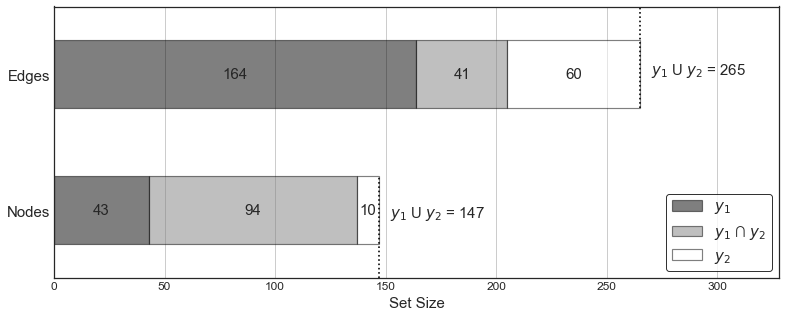

In [24]:
# Set comprehension
y1_edges = set(clairvoyance_data["y1"]["edges"]) - set(clairvoyance_data["y2"]["edges"])
y2_edges = set(clairvoyance_data["y2"]["edges"]) - set(clairvoyance_data["y1"]["edges"])
y1_nodes = set(clairvoyance_data["y1"]["nodes"]) - set(clairvoyance_data["y2"]["nodes"])
y2_nodes = set(clairvoyance_data["y2"]["nodes"]) - set(clairvoyance_data["y1"]["nodes"])
nodes_consensus = set(clairvoyance_data["y1"]["nodes"]) & set(clairvoyance_data["y2"]["nodes"])
edges_consensus = set(clairvoyance_data["y1"]["edges"]) & set(clairvoyance_data["y2"]["edges"])
nodes_union = set(clairvoyance_data["y1"]["nodes"]) | set(clairvoyance_data["y2"]["nodes"])
edges_union = set(clairvoyance_data["y1"]["edges"]) | set(clairvoyance_data["y2"]["edges"])

# Organize data to plot bar-chart-styled venn diagram
df = pd.DataFrame(
    {
    "Nodes":{"${y_1}$": len(y1_nodes), "${y_1}$ ∩ ${y_2}$":len(nodes_consensus), "${y_2}$":len(y2_nodes)},
    "Edges":{"${y_1}$": len(y1_edges), "${y_1}$ ∩ ${y_2}$":len(edges_consensus), "${y_2}$":len(y2_edges)},
})

# Plot stacked barchart
with plt.style.context("seaborn-white"):
    fig, ax = plt.subplots(figsize=(13,5))
    # Barchart
    df.T.plot(kind="barh", stacked=True, ax=ax, cmap="gray", edgecolor="black", linewidth=1.1618, alpha=0.5)
    ax.set_xlabel("Set Size", fontsize=15)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=15, rotation=0)
    ax.set_xticklabels(map(int,ax.get_xticks()), fontsize=12, rotation=0)
    # Draw lines for union of nodes/edges
    ax.plot( [len(nodes_union), len(nodes_union)], [min(ax.get_ylim()),0.25], color="black", linewidth=1.618, linestyle=":")
    ax.text( len(nodes_union)+5, -0.05, "${y_1}$ U ${y_2}$ = %d"%(len(nodes_union)), ha="left", fontsize=15)
    ax.plot( [len(edges_union), len(edges_union)],[0.75,max(ax.get_xlim())], color="black", linewidth=1.618, linestyle=":")
    ax.text(len(edges_union)+5, 1, "${y_1}$ U ${y_2}$ = %d"%(len(edges_union)), ha="left", fontsize=15)
    ax.xaxis.grid(True)
    # Plot annotations
    for p in ax.patches:
        width, height = p.get_width(), p.get_height()
        x, y = p.get_xy() 
        ax.text(x+width/2, 
                y+height/2, 
                int(width), 
                horizontalalignment='center', 
                verticalalignment='center',
                fontsize=15,
               )
    # Legend
    ax.legend(**{'fontsize': 15,
             'frameon': True,
             'facecolor': 'white',
             'edgecolor': 'black',
             'loc': 'lower right',
            })
    ax.set_xlim((min(ax.get_xlim()), max(ax.get_xlim())+50))    

## Hierarchical Ensemble of Classifiers Model

In [25]:
# Set up training data
X_training = ds_perturbations.X
Y_training = topology.get_target_matrix().loc[X_training.index]
y_training = topology.y[X_training.index]

# Create dataset
ds_training = sy.Dataset(
    data=X_training, 
    metadata_observations=Y_training,
    name="HEC",
)

# Add sub-model subsets as versions
for submodel in topology.submodels:
    
    X_submodel = submodel_data[submodel]["X"]
    y_submodel = submodel_data[submodel]["y"]
    cv_submodel = submodel_data[submodel]["cv"]
    
    # Training data
    ds_training.add_version(
        name_version=submodel, 
        data=submodel_data[submodel]["X"],
        X=X_submodel,
        y=y_submodel,
        cv_labels=cv_submodel.index,
        cv=cv_submodel.values.tolist(),
        clf=clairvoyance_data[submodel]["clf"],
        features=clairvoyance_data[submodel]["features"],
        edges=clairvoyance_data[submodel]["edges"],
        nodes=clairvoyance_data[submodel]["nodes"],
        hyperparameters=clairvoyance_data[submodel]["hyperparameters"],
    )
    

In [26]:
# Create the HEC model
model = HEC(
    name="v5.0", 
    attr_type="edge", 
    obsv_type="sample", 
    class_type="nutritional_status", 
    verbose=True
)


# Add paths in the graph
paths = topology.get_paths()
model.add_paths(topology.get_paths())

# -------------------------------------------------
# Model fitting and cross-validation [Full Dataset]
# -------------------------------------------------
# Add submodels to HEC
for submodel in topology.submodels:
    # Training data
    X_submodel = ds_training.get_dataset_field(submodel, "X")
    y_submodel = ds_training.get_dataset_field(submodel, "y")
    
    # Clairvoyance-optimized gene sets
    features = ds_training.get_dataset_field(submodel, "features") # Let's keep it agnostic to biological concepts at this point
    
    # Logistic Regression sub-models with hyperparameters defined earlier
    clf = ds_training.get_dataset_field(submodel, "clf")
    
    # Custom cross-validation pairs
    cv_labels = ds_training.get_dataset_field(submodel, "cv_labels")
    cv = ds_training.get_dataset_field(submodel, "cv")
    index = X_submodel.index
    
    # Add sub-model
    model.add_submodel(name=submodel, clf=clf, attributes=features.tolist(), cv=cv, index=index, cv_labels=cv_labels)
    
    # Fit sub-model
    model.get_classifier(submodel).fit(X_submodel.loc[:,features], y_submodel)
    
# Fit the model using the attribute and target matrices
model.fit(X_training, Y_training)

# Evaluate the model
print("HEC model LSOCV accuracy", model.cross_validate(X_training, Y_training).mean())#, mode="directional" )


# # Save model
# model.save_model(path="./Data/HEC.pkl") # Will probably change this to .to_file in future versions

# # Load model
# model = sy.io.read_object("./Data/HEC.pkl")

Cross-validating: 34it [00:00, 43.19it/s]

HEC model LSOCV accuracy 1.0


In [27]:
# Manually cross-validate the HEC model
root_submodel = model.root_submodel
assert root_submodel == "y1", "`root_submodel` should be 'y1'" #root_submodel = "y1". Using `y1` b/c it is the root decision that all of the data passes through in the HEC
Y_hats = list()
for (cross_validation_label, (idx_tr, idx_te)) in tqdm(zip(ds_training.get_dataset_field(root_submodel, "cv_labels"), ds_training.get_dataset_field(root_submodel, "cv")), "Manual cross-validation"): 
    # Partition training/testing sets
    X_tr = X_training.iloc[idx_tr,:]
    X_te = X_training.iloc[idx_te,:]
    Y_tr = Y_training.iloc[idx_tr,:]
    Y_te = Y_training.iloc[idx_te,:]
    
    # Fit model
    model.fit(X_tr, Y_tr, ignore_submodel_index=True) # Use `ignore_submodel_index` when manually cross-validating
    
    # Get probabilities per sub-model
    Y_hat = model.predict_proba(X_te )
    Y_hats.append(Y_hat)
Y_hats = pd.concat(Y_hats)

Manual cross-validation: 34it [00:00, 39.77it/s]


## Interpreting the HEC model

In [28]:
# Extract fitted edges weights per sub-model
df_AN_connectivity__edges = dict()#pd.DataFrame()

for submodel in model.submodels:
    edge_weights = pd.Series(clairvoyance_data[submodel]["clf"].coef_.ravel(), index=clairvoyance_data[submodel]["features"], name=submodel)
    df_AN_connectivity__edges[(submodel, "Weight")] = edge_weights.to_dict() # Note: Can use this when not manually cross-validating submodels within the model object: pd.Series(model.get_classifier(submodel).coef_.flatten(), index=model.get_attributes(submodel), name=submodel)
    df_AN_connectivity__edges[(submodel, "|Weight|")] = edge_weights.abs().to_dict()

# View the weights
df_AN_connectivity__edges = pd.DataFrame(df_AN_connectivity__edges)
df_AN_connectivity__edges.columns = pd.MultiIndex.from_tuples(df_AN_connectivity__edges.columns, names=["Sub-model", "Signed"])
df_AN_connectivity__edges.head()

Sub-model                     y1                  y2          
Signed                    Weight  |Weight|    Weight  |Weight|
(Otu000965, Otu000906) -0.511643  0.511643       NaN       NaN
(Otu000965, cortisol)   0.322399  0.322399  0.109828  0.109828
(Otu000035, Otu000101) -0.288411  0.288411 -0.125755  0.125755
(Otu000005, Otu000494) -0.381299  0.381299       NaN       NaN
(Otu000404, sobr)       0.390190  0.390190       NaN       NaN

Inferred association as `dissimilarity`
/Users/jespinoz/anaconda3/envs/soothsayer5_env/lib/python3.8/site-packages/soothsayer/ordination/ordination.py:74: UserWarning: Using `show_features` to create a `biplot` is experimental.
  warnings.warn("Using `show_features` to create a `biplot` is experimental.")
Selected 4 features:
[('y1', 'WN'), ('y1', 'y2'), ('y2', 'MAM'), ('y2', 'SAM')]


(<Figure size 576x360 with 1 Axes>,
 <AxesSubplot:xlabel='PCoA.1(0.6831)', ylabel='PCoA.2(0.3169)'>,
 <matplotlib.collections.PathCollection at 0x7fc62b4bd790>)

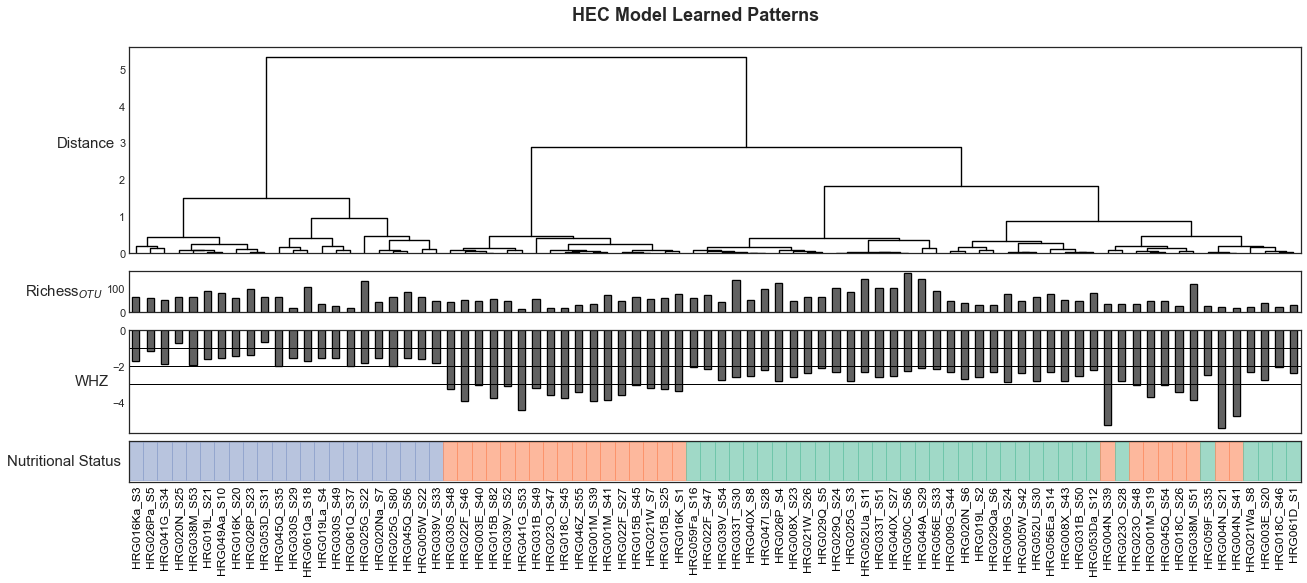

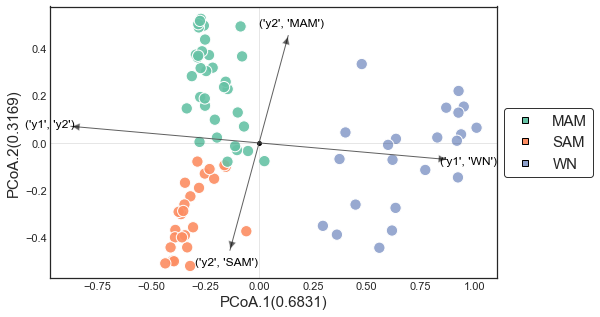

In [29]:
# Extracting the learned patterns by the HEC model
df_dism = sy.symmetry.pairwise(Y_hats, metric="euclidean", axis=0)

# Agglomerative hierarchical clustering
ahc = sy.Agglomerative(df_dism)
ahc.add_secondary_class("Nutritional Status", mapping=ds_perturbations.y, class_colors=colors_status.class_colors)
ahc.add_track("Richess$_{OTU}$", df_richness.loc[ahc.leaves, "OTU"].fillna(0))
ahc.add_track("WHZ", ds_perturbations.metadata_observations["WHZ"], horizontal_lines=[-1,-2,-3], percent_of_figure=50 )
ahc.plot( show_leaves=True, figsize=(21,8), show_track_ticks=True, title="HEC Model Learned Patterns")

# PCoA
sy.ordination.PrincipalCoordinatesAnalysis(df_dism, data=Y_hats).plot(show_features=True, color_arrow="black",color_feature="black", arrow_scale=2, c=colors_status.obsv_colors, figsize=(8,5), legend=colors_status.class_colors)

## Aggregate networks

(147, 4) (265, 4)


Sub-model                     y1                  y2          
Signed                    Weight  |Weight|    Weight  |Weight|
(Otu000965, Otu000906) -0.511643  0.511643       NaN       NaN
(Otu000965, cortisol)   0.322399  0.322399  0.109828  0.109828
(Otu000035, Otu000101) -0.288411  0.288411 -0.125755  0.125755
(Otu000005, Otu000494) -0.381299  0.381299       NaN       NaN
(Otu000404, sobr)       0.390190  0.390190       NaN       NaN

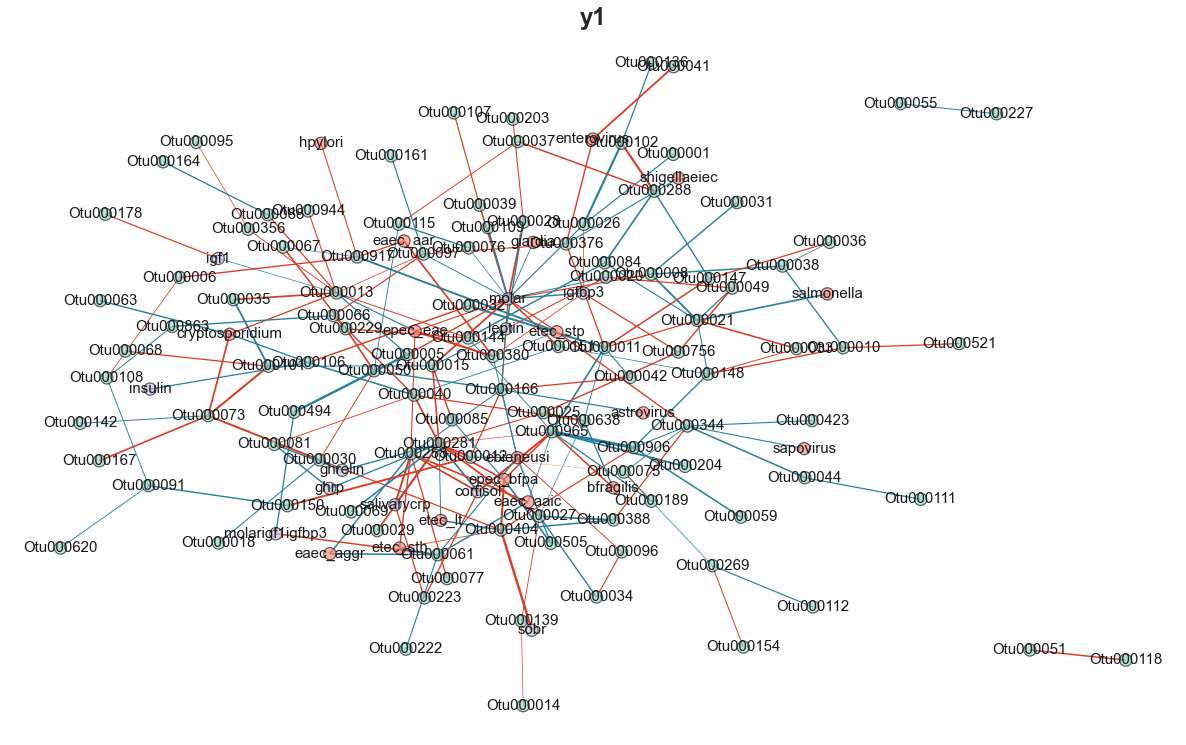

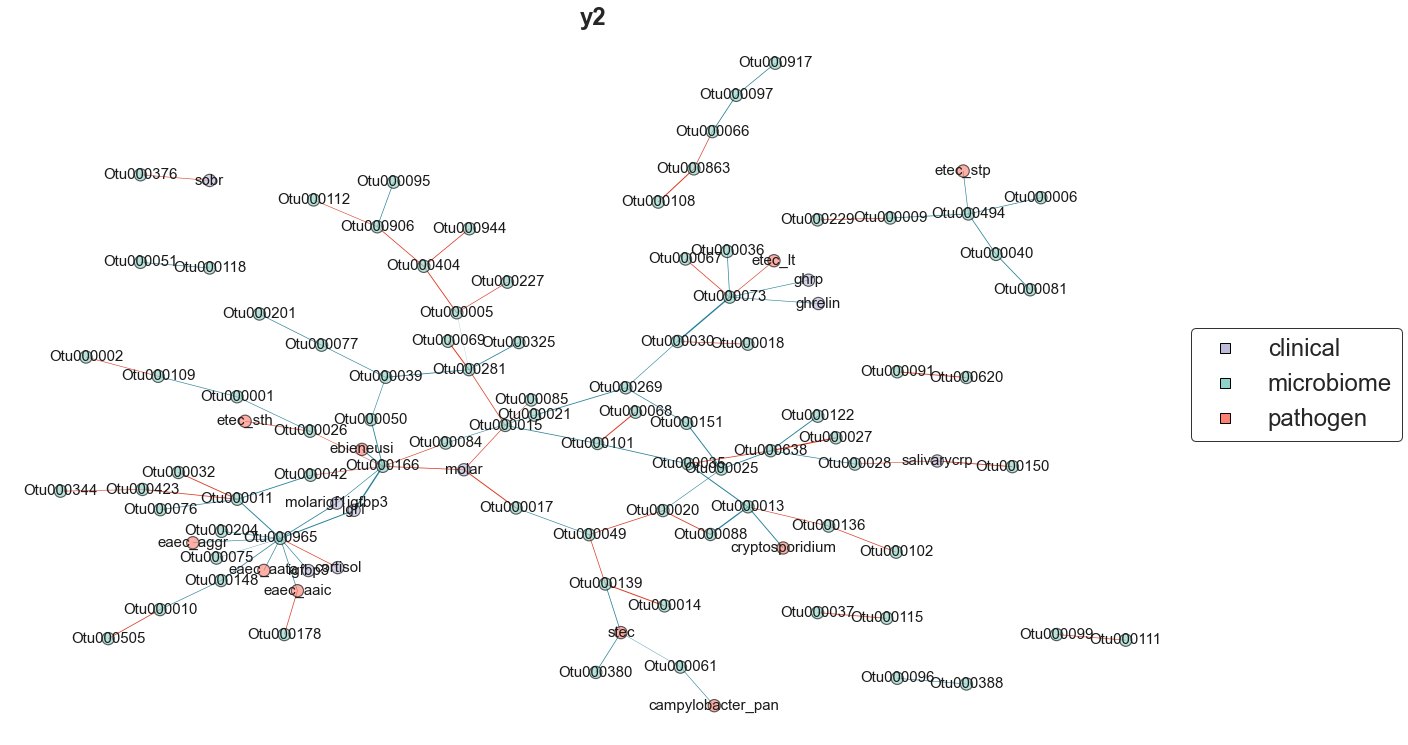

In [30]:
# Node metadata
df_descriptions = sy.io.read_dataframe("./Data/clinical_descriptions.tsv")

data = defaultdict(dict)
for node in sy.utils.flatten(clairvoyance_data["y1"]["edges"] | clairvoyance_data["y2"]["edges"], set):
    for submodel in ["y1", "y2"]:
        data[node][submodel] = node in clairvoyance_data[submodel]["nodes"]
        
df_meta_nodes = pd.DataFrame(data).T.sort_index()
df_meta_nodes = pd.concat([df_meta_nodes, ds_otus.metadata_attributes.loc[df_meta_nodes.index & ds_otus.metadata_attributes.index,['Taxonomy','Phylum', 'Class', 'Order','Family', 'Genus', 'Species']]], axis=1)
df_meta_nodes.loc[df_descriptions.index & df_meta_nodes.index, "Description"] = df_descriptions["Description"]

# Aggregate Networks
df_AN_connectivity__nodes = dict()
for submodel in model.submodels:
    
    # Create aggregate network for each sub-model
    edge_weights = df_AN_connectivity__edges[(submodel, "Weight")].dropna()#[lambda w: w != 0] 
    graph = nx.Graph(name=submodel)
    for edge, w in edge_weights.items():
        edge = tuple(edge)
        graph.add_edge(*edge, weight=abs(w), sign=np.sign(w))
    
    # Node connectivity
    node_weights = pd.Series(dict(nx.degree(graph, weight="weight"))) # Weighted degree
    df_AN_connectivity__nodes[(submodel, "Connectivity(weighted-degree)")] = node_weights.to_dict()
    df_AN_connectivity__nodes[(submodel, "Connectivity(weighted-degree_scaled)")] = (node_weights/node_weights.sum()).to_dict()
    
    # Get positions
    pos = nx.nx_agraph.graphviz_layout(graph, prog="neato")
    coefs = edge_weights[list(map(frozenset, graph.edges()))]
    edgecolors = coefs.map(lambda x: {True:sy.utils.COLOR_POSITIVE, False: sy.utils.COLOR_NEGATIVE}[x > 0])
    edge_widths = coefs.abs()*6.18
    with plt.style.context("seaborn-white"):
        fig, ax = plt.subplots(figsize=(21,13))
        nx.draw_networkx_nodes(graph, pos=pos, alpha=0.618,node_size=150, edgecolors="black", linewidths=1.1618, ax=ax, node_color=colors_modality.obsv_colors[list(graph.nodes())])
        nx.draw_networkx_edges(graph, pos=pos, ax=ax, style="-", width=edge_widths, edge_color=edgecolors)
        nx.draw_networkx_labels(graph, labels=dict(zip(graph.nodes(), graph.nodes())), pos=pos, ax=ax, style=":", font_size=15)
        ax.axis("off")
        if submodel == "y2":
            legend_kws = sy.utils.LEGEND_KWS
            legend_kws["fontsize"] = 24
            ax.legend(*sy.utils.format_mpl_legend_handles(colors_modality.class_colors), markerscale=1.618, **legend_kws)
        ax.set_title("{}".format(submodel), fontsize=24, fontweight="bold")
    # Save
    sy.io.write_object(graph, "./Data/AN_{}.graph.networkx.pkl".format(submodel))
    sy.io.write_object(pos, "./Data/AN_{}.pos.dict.pkl".format(submodel))


# Set multiindex
df_AN_connectivity__nodes = pd.DataFrame(df_AN_connectivity__nodes)
df_AN_connectivity__nodes.columns = pd.MultiIndex.from_tuples(df_AN_connectivity__nodes.columns, names=["Sub-model", "Scaled"])

# View edge metadata
print(df_AN_connectivity__nodes.shape, df_AN_connectivity__edges.shape)
df_AN_connectivity__edges.head()

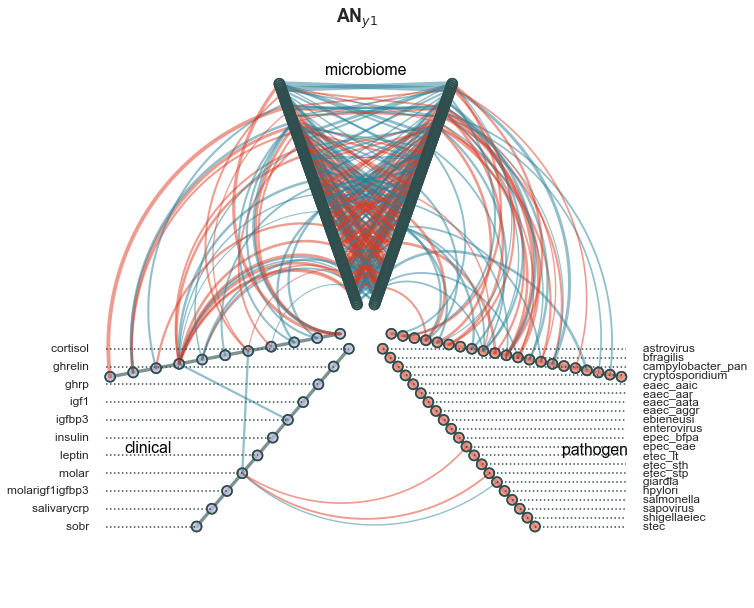

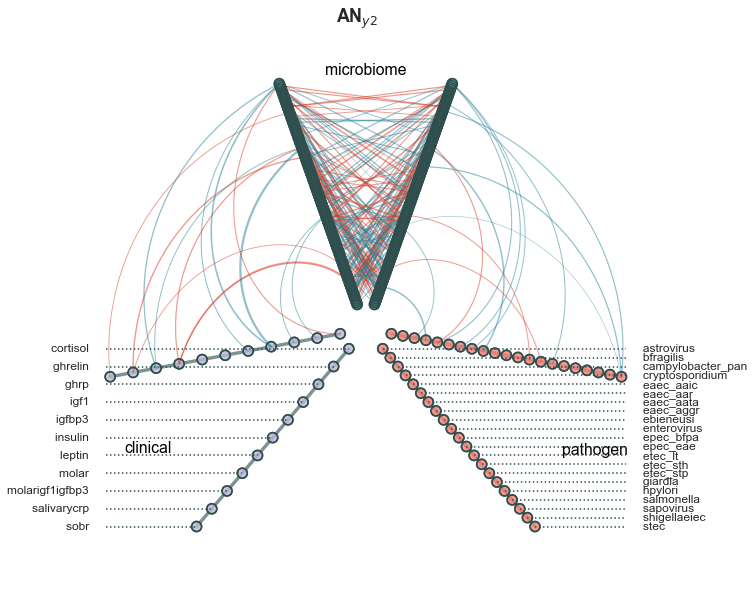

In [31]:
# Hive plots
aggregate_networks = dict()
for submodel in model.submodels:
    # Create a full-connected network to use as input for hive plots
    sym = hx.Symmetric(df_AN_connectivity__edges[(submodel, "Weight")])
    # Fill the empty edge weights with zeros
    sym.weights = sym.weights.fillna(0)
    aggregate_networks[submodel] = sym
    # Get colors for edges based on sign
    edge_colors = sym.weights.map(lambda x:{True:sy.utils.COLOR_POSITIVE, False:sy.utils.COLOR_NEGATIVE}[x>0])
    # Create Hive
    hive = hx.Hive(sym, name=submodel)
    # Get non-microbiome nodes to label (there are too many OTUs to label)
    show_node_labels = sy.utils.flatten(sym.weights.index[sym.weights.index.map(lambda edge: list(map(lambda node: y_modality[node], edge)).count("microbiome") < 1)], set)
    # Add each modality as an axis
    for modality, index in sorted(sy.utils.pd_series_collapse(y_modality, type_collection=pd.Index).items(), key=lambda x:{"microbiome":0, "clinical":1, "pathogen":2}[x[0]]):
        nodes = sorted(index & sym.nodes)
        hive.add_axis(name_axis=modality, nodes=nodes, colors=colors_modality.class_colors[modality], split_axis=True)
    hive.compile(inner_radius=100)
    # Plot the hive
    hive.plot(style="white", edge_colors=edge_colors, func_edgeweight=lambda w:w*10, show_node_labels=show_node_labels, figsize=(10,10), pad_axis_label=-150, title="AN$_{%s}$"%(submodel))

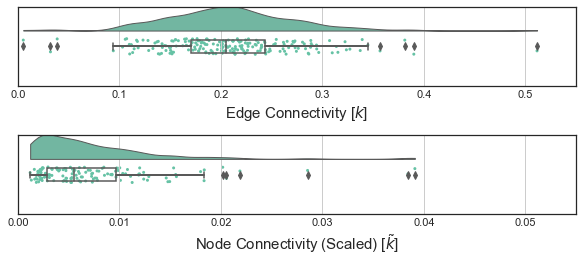

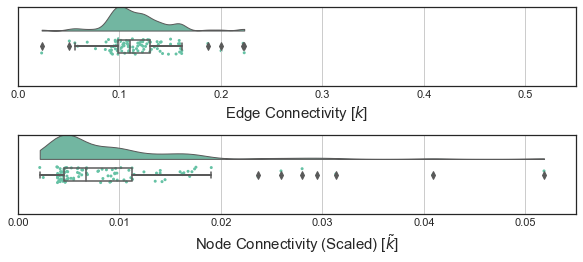

In [32]:
# Connectivity plots
with plt.style.context("seaborn-white"):
    for submodel in model.submodels:
        fig, axes = plt.subplots(figsize=(10, 3.82), nrows=2, gridspec_kw={"hspace":0.618})
        # Edge connectivity
        ax=axes[0]
        edge_weights = df_AN_connectivity__edges[(submodel,"|Weight|")]
        pt.RainCloud(x=edge_weights, orient="horizontal", ax=ax, width_box=0.1618, width_viol=0.618)
        ax.xaxis.grid(True)
        ax.set_xlabel("Edge Connectivity [$k$]", fontsize=15)
        ax.set_xlim((0,0.55))
        # Node connectivity
        ax = axes[1]
        node_weights = df_AN_connectivity__nodes[(submodel,"Connectivity(weighted-degree_scaled)")]
        pt.RainCloud(x=node_weights, orient="horizontal", ax=ax, width_box=0.1618, width_viol=0.618)
        ax.xaxis.grid(True)
        ax.set_xlabel(r"Node Connectivity (Scaled) [$\tilde{k}$]", fontsize=15)
        ax.set_xlim((0,0.055))

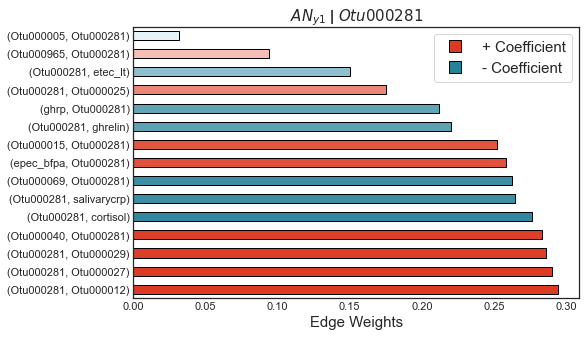

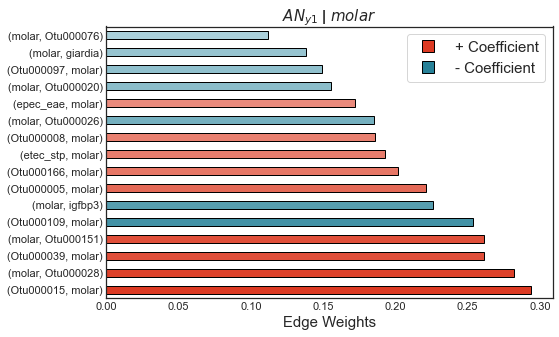

In [34]:
# High connectivity nodes
y1_weights__signed = df_AN_connectivity__edges[("y1","Weight")].dropna().sort_values(ascending=False)
y1_weights = y1_weights__signed.abs().sort_values(ascending=False)

y2_weights__signed = df_AN_connectivity__edges[("y2","Weight")].dropna().sort_values(ascending=False)
y2_weights = y2_weights__signed.abs().sort_values(ascending=False)
# y1_weights.mean(), y2_weights.mean(), y1_weights.sum(), y2_weights.sum()

# Otu000281
node = "Otu000281"
z = y1_weights[y1_weights.index.map(lambda x: node in x)].sort_values(ascending=False)
with plt.style.context("seaborn-white"):
    fig, ax = plt.subplots(figsize=(8,5))
    z.plot(kind="barh", color=sy.utils.map_colors(y1_weights__signed[z.index],mode=3, cmap=sy.utils.CMAP_DIVERGING, vmin=-z.max(), vmax=z.max(), format="hex"), linewidth=1, edgecolor="black", ax=ax)
    ax.set_xlabel("Edge Weights", fontsize=15)
    ax.set_title("$AN_{y1}$ | $%s$"%(node), fontsize=15, fontweight="bold")
    ax.legend(*sy.utils.format_mpl_legend_handles({"+ Coefficient":sy.utils.COLOR_POSITIVE, "- Coefficient":sy.utils.COLOR_NEGATIVE}), fontsize=15, frameon=True, markerscale=2)

# molar
node = "molar"
z = y1_weights[y1_weights.index.map(lambda x: node in x)].sort_values(ascending=False)
with plt.style.context("seaborn-white"):
    fig, ax = plt.subplots(figsize=(8,5))
    z.plot(kind="barh", color=sy.utils.map_colors(y1_weights__signed[z.index],mode=3, cmap=sy.utils.CMAP_DIVERGING, vmin=-z.max(), vmax=z.max(), format="hex"),  linewidth=1, edgecolor="black", ax=ax)
    ax.set_xlabel("Edge Weights", fontsize=15)
    ax.set_title("$AN_{y1}$ | $%s$"%(node), fontsize=15, fontweight="bold")
    ax.legend(*sy.utils.format_mpl_legend_handles({"+ Coefficient":sy.utils.COLOR_POSITIVE, "- Coefficient":sy.utils.COLOR_NEGATIVE}), fontsize=15, frameon=True, markerscale=2)

  0%|          | 0/34 [00:00<?, ?it/s]/Users/jespinoz/anaconda3/envs/soothsayer5_env/lib/python3.8/site-packages/soothsayer/networks/networks.py:1180: UserWarning: `TemporalGraph` is experimental.  Functionality must be evaluated, plotting functions, must be coded, and much more.  In the current state, this can be used to create create global temporal networks via`teneto.TemporalNetwork` and `nx.OrderedDiGraph` in addition to each timepoint-specific undirected network via `nx.Graph`.
  warnings.warn("`TemporalGraph` is experimental.  Functionality must be evaluated, plotting functions, must be coded, and much more.  In the current state, this can be used to create create global temporal networks via`teneto.TemporalNetwork` and `nx.OrderedDiGraph` in addition to each timepoint-specific undirected network via `nx.Graph`.")
  3%|▎         | 1/34 [00:01<00:49,  1.51s/it]/Users/jespinoz/anaconda3/envs/soothsayer5_env/lib/python3.8/site-packages/soothsayer/networks/networks.py:1180: UserWarn

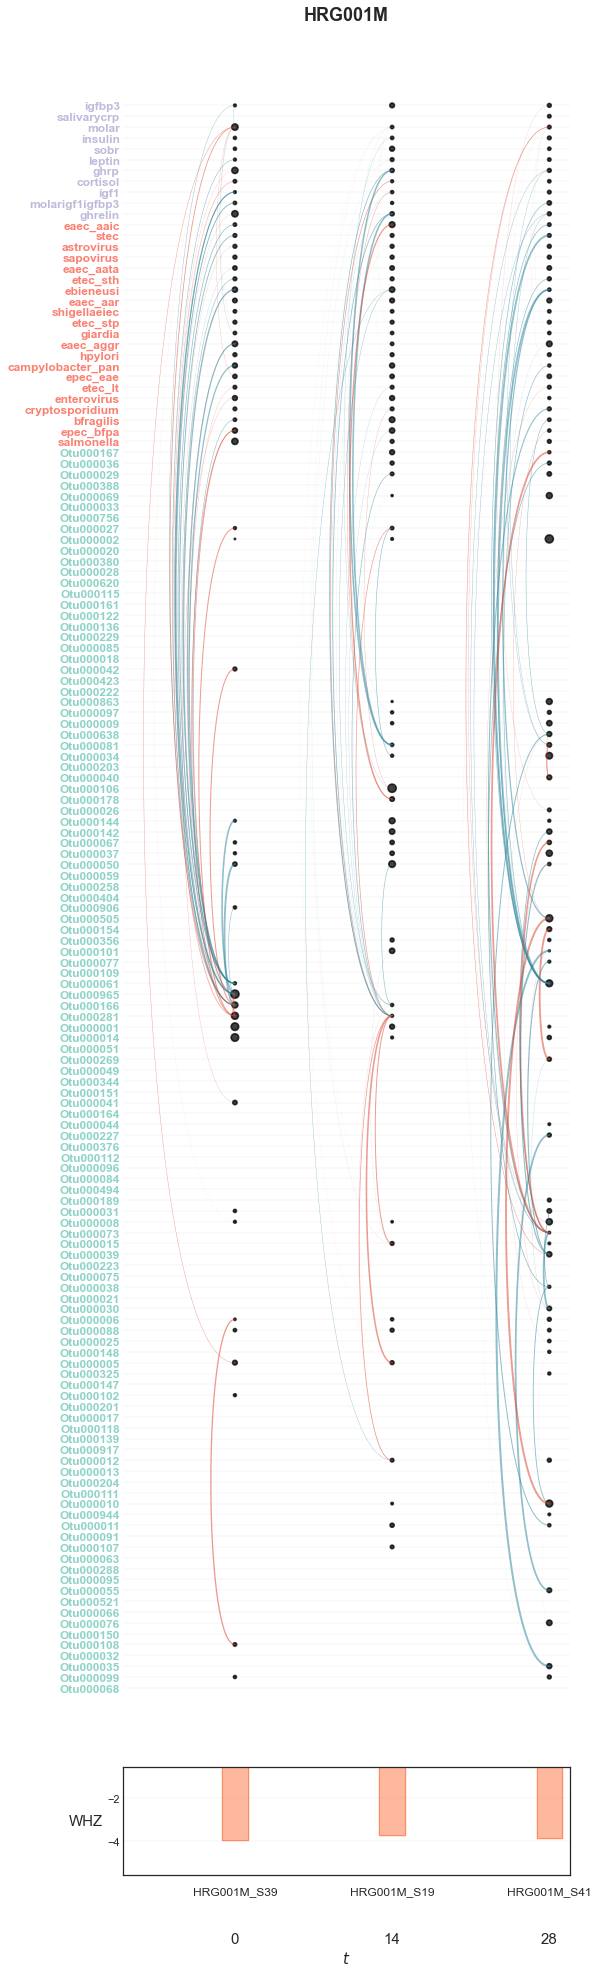

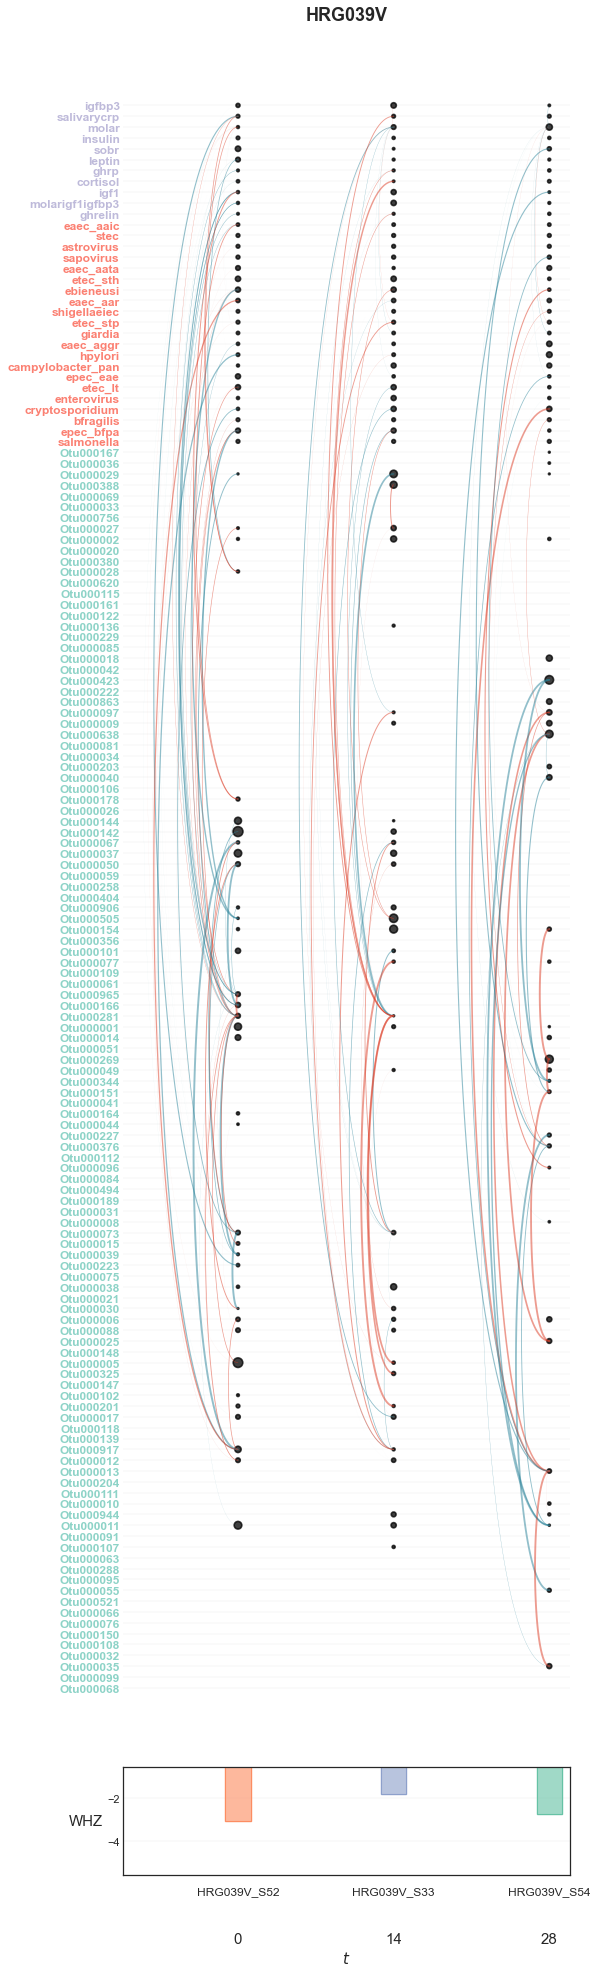

In [37]:
# Get timepoints for a particular subject
whz_pad = 0.1
whz_lim = (ds_perturbations.metadata_observations["WHZ"].min() - whz_pad, ds_perturbations.metadata_observations["WHZ"].max() + whz_pad)

#
nodelist = pd.Index(tree_16s.get_leaf_names() + y_modality[list(filter(lambda x: not x.startswith("Otu"), nodes_union))].sort_values(ascending=False).index.tolist())
for id_subject, perturbations in tqdm(ds_perturbations[None].loc[:,edges_union].groupby(ds_perturbations.metadata_observations["SubjectID"])):
    if id_subject in {"HRG039V", "HRG001M"}:
        
        # Perturbation profiles
        perturbations = perturbations.dropna(how="any", axis=0)
        
        # Sort the timepoints
        days = ds_multimodal.metadata_observations.loc[perturbations.index, "Visit[Day]"].astype(int).sort_values()
        perturbations = perturbations.loc[days.index]

        # Create temporal graph object
        temporal_graph = sy.networks.TemporalNetwork(id_subject, edge_type="perturbation", time_unit="day")
        
        # Add each visit
        visits = list()
        for i, (id_visit, timepoint) in enumerate(days.iteritems(), start=0):
            connections = perturbations.loc[id_visit].dropna()
            temporal_graph.add_timepoint(t=timepoint, data=connections, id=id_visit) #! Should id be required? 
            visits.append(id_visit)
        temporal_graph.compile()                                              

        # Transform CLR -> MixedLM residuals to the real, fill missing values with zeros
        df_node_sizes = np.exp(ds_multimodal["residuals"].loc[visits]).T.fillna(0).loc[nodelist & pd.Index(temporal_graph.nodes_)]
        
        # Relabel sample identifiers to timepoint labels #! The best way to do this? 
        df_node_sizes.columns = df_node_sizes.columns.map(lambda id_visit: ds_perturbations.metadata_observations.loc[id_visit, "Visit[Day]"])
        
        # Get timepoint colors for the track
        track_colors = colors_status.obsv_colors[visits].copy()
        track_colors.index = track_colors.index.map(lambda id_visit: ds_perturbations.metadata_observations.loc[id_visit, "Visit[Day]"])
        
        # Add tracks (only one in this example)
        for name in ["WHZ"]:
            track_data = ds_perturbations.metadata_observations.loc[visits,name].copy()
            track_data.index = track_data.index.map(lambda id_visit: ds_perturbations.metadata_observations.loc[id_visit, "Visit[Day]"])
            temporal_graph.add_track(
                 name=name.upper(), 
                 data=track_data, 
                 plot_type="bar",
                 color=track_colors,
                 ylim=whz_lim, 
                 percent_of_figure=6.18,
                 pad=0,
            )

        # Plot arcs
        fig, axes = temporal_graph.plot_arcs(nodelist=nodelist & df_node_sizes.index, node_sizes=df_node_sizes*15, show_timepoint_identifiers=True, show_tracks=True, figsize=(8,34))
            
        # Color labels
        for tick in axes[0].get_yticklabels():
            tick.set_color(colors_modality.obsv_colors[tick.get_text()])
            tick.set_fontweight("bold")


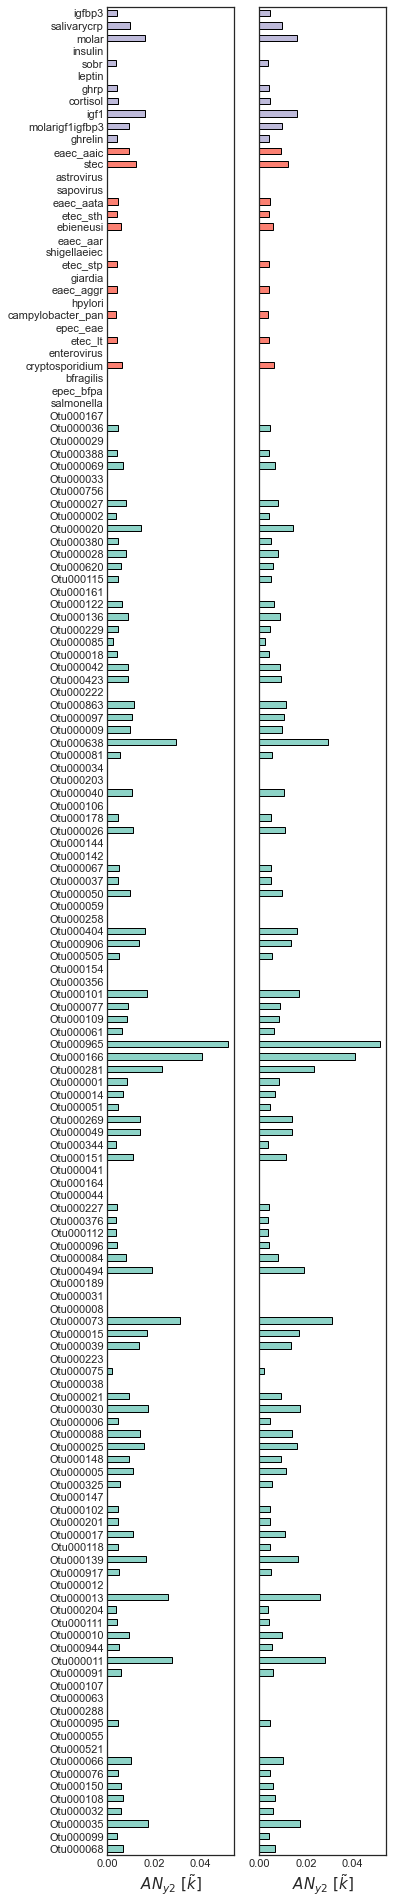

In [46]:
with plt.style.context('seaborn-white'):
    fig, axes = plt.subplots(figsize=(5,34), ncols=2, sharex=True, sharey=True)
    for i, g in enumerate(model.submodels):
        df_AN_connectivity__nodes.loc[nodelist & df_AN_connectivity__nodes.index, (submodel, "Connectivity(weighted-degree_scaled)")].fillna(0).plot(kind="barh", color=colors_modality.obsv_colors[nodelist & df_AN_connectivity__nodes.index], ax=axes[i], edgecolor="black", linewidth=1)
        axes[i].set_xlabel("$AN_{%s}\ [%s]$"%(submodel, r"\tilde{k}"), fontsize=15)
    

In [ ]:
df_

In [ ]:
print("Total Duration:", sy.utils.format_duration(t0))